# Some visualizations of the dataset of the Optiver competition!

## Import data and libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

In [2]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

# **EDA**

### plotting some data for a single day of a given security

In [3]:
cols_to_plot = ['imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', ]

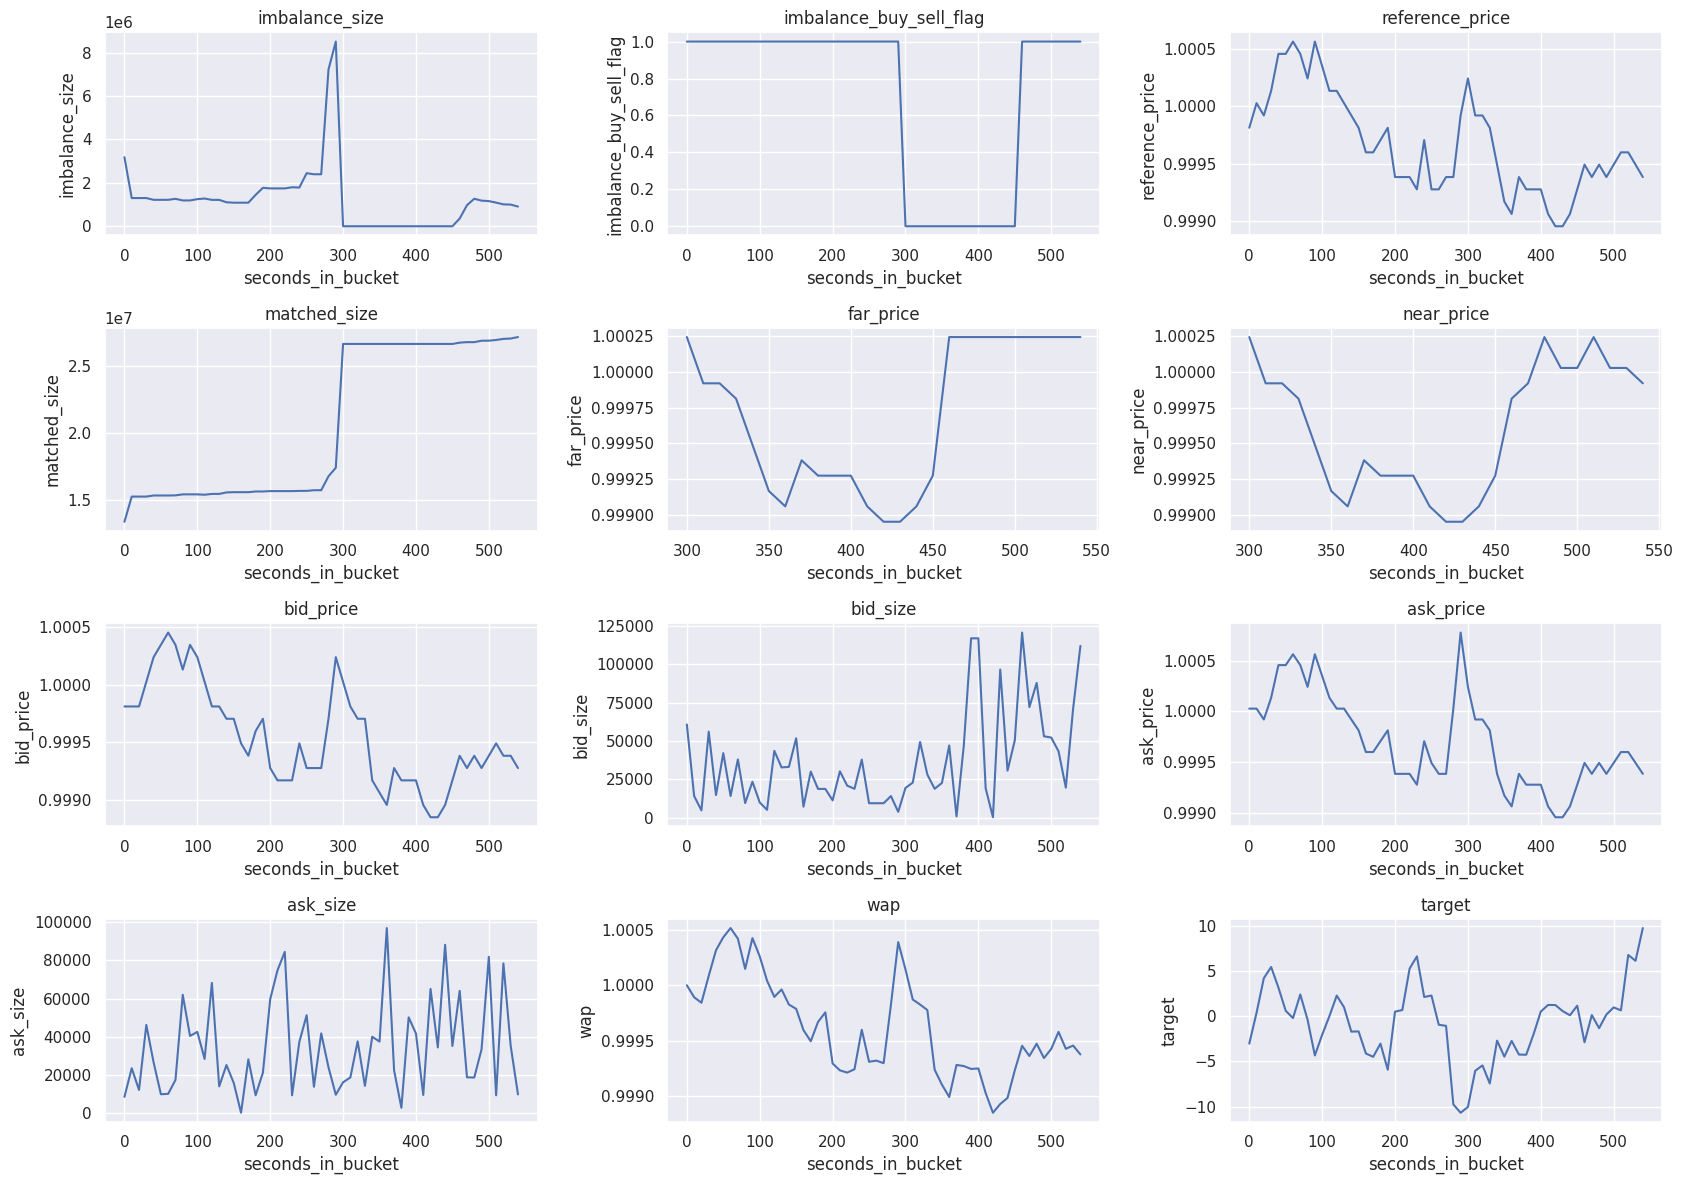

In [4]:
fig, axes = plt.subplots(4, 3, figsize = (17, 12))
_ = df.query("stock_id == 0 & date_id == 0")
for i, col in enumerate(cols_to_plot):
    ax = axes[i // 3, i % 3 ]
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

### exploring bid/ask spread

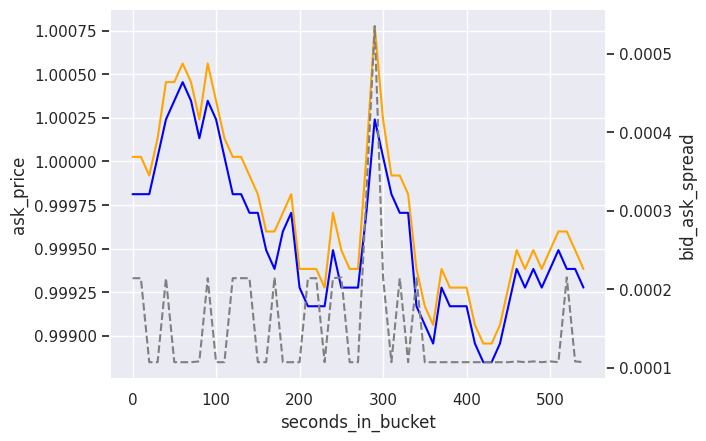

In [5]:
_ = df.query("stock_id == 0 & date_id == 0").assign(bid_ask_spread = lambda df_ : df_.ask_price - df_.bid_price)
sns.lineplot(data = _, x = 'seconds_in_bucket', y = 'ask_price', color = 'orange' )
sns.lineplot(data = _, x = 'seconds_in_bucket', y = 'bid_price', color = 'blue' )
ax2 = plt.twinx()
sns.lineplot(data = _, x = 'seconds_in_bucket', y = 'bid_ask_spread', color = 'gray', linestyle = 'dashed', ax = ax2 )
ax2.grid(False)
plt.show()

### plotting some other data for a single day of a given security

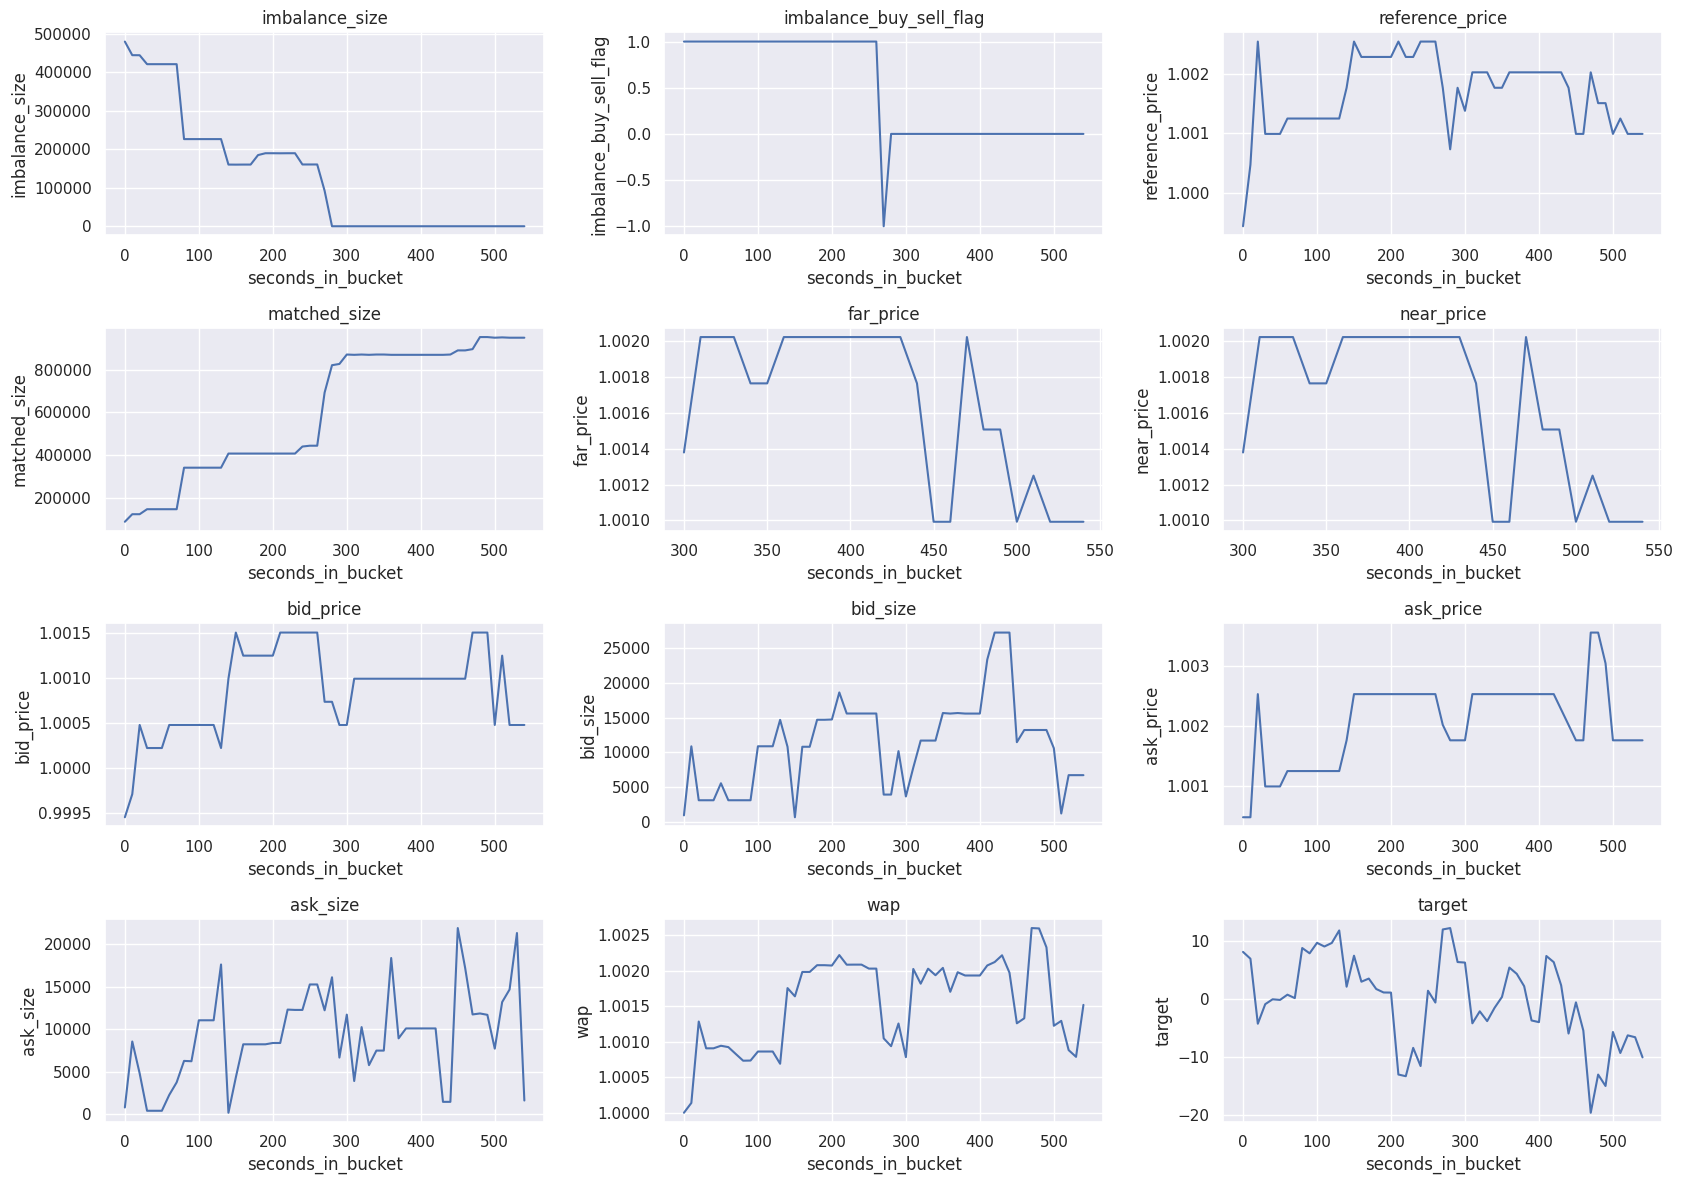

In [6]:
fig, axes = plt.subplots(4, 3, figsize = (17, 12))
_ = df.query("stock_id == 138 & date_id == 5")
for i, col in enumerate(cols_to_plot):
    ax = axes[i // 3, i % 3 ]
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

### exploring correlation within variables

In [7]:
corr = _.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


#### considerations
* *'seconds in bucket'* + is highly correlated with *'matched size'*, since it seems to be the total amount of deals done in the marketplace and cannot decrease (verify with more securities later)
* *'imbalance size'* seems highly correlated with *'bid/ask spread'*. It makes sense since the higher the imbalance, the higher the distannce between the seller and the bidder
* Deepen the meaning of all the prices there: reference price, far_price, near_price, wap, target
* No variable seems highly correlated with the target, maybe I can try to take the variables at second +60 (target is 60 sec future move of wap minus 60 sec future move of a synthetic index of the market)

#### verify point 1 whith another stock/day

### prices

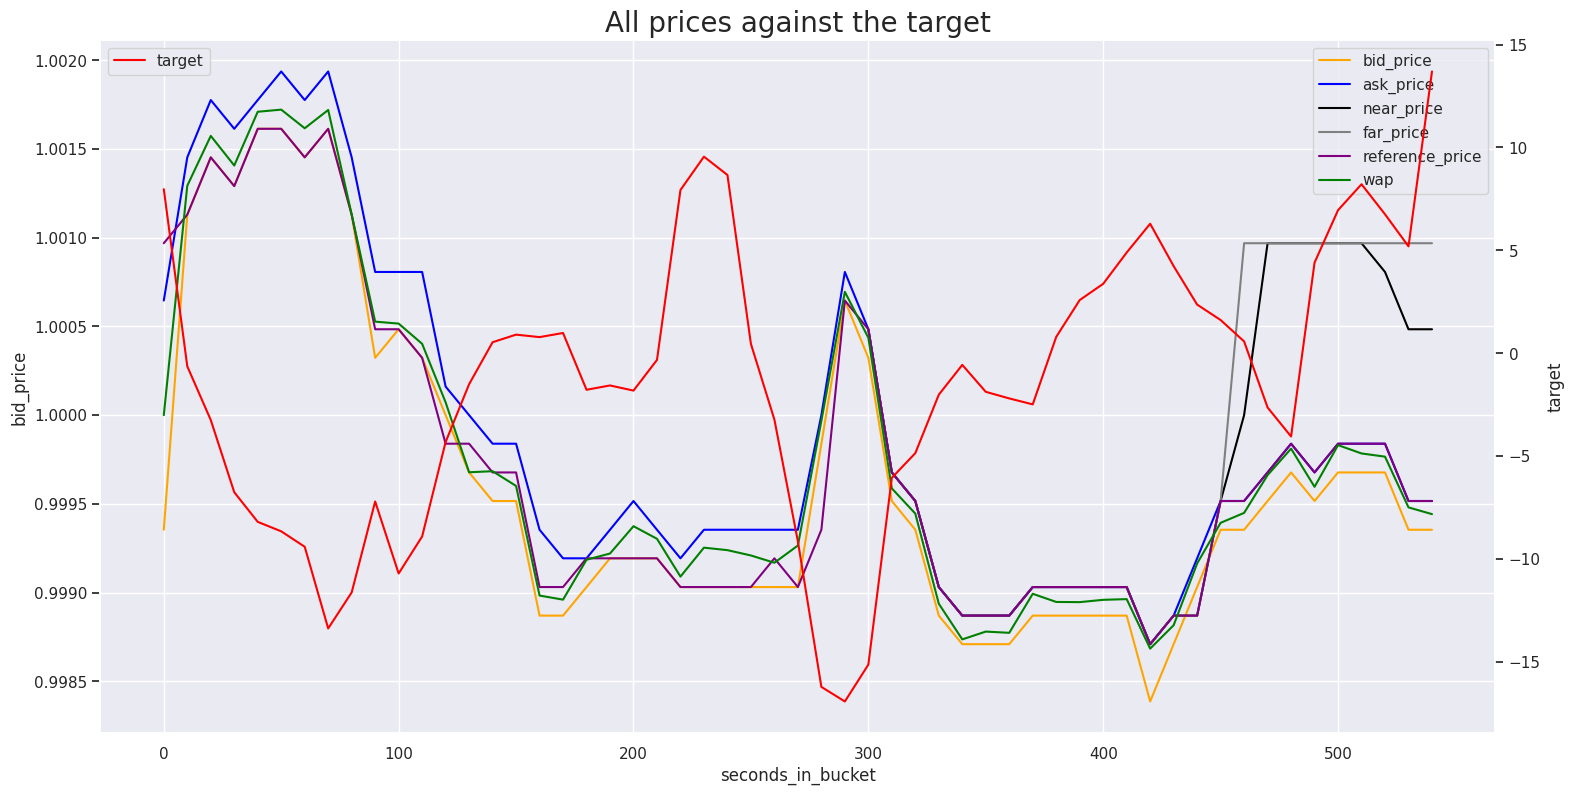

In [8]:
sns.set(rc = {'figure.figsize': (18,9)})
_ = df.query("stock_id == 9 & date_id == 0").assign(bid_ask_spread = lambda df_ : df_.ask_price - df_.bid_price)
for col, color in zip(['bid_price', 'ask_price', 'near_price', 'far_price', 'reference_price', 'wap'], ['orange', 'blue','black', 'gray', 'purple', 'green']):
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, color = color, label = col)
ax2 = plt.twinx()
ax2.grid(False)
sns.lineplot(data = _, x = 'seconds_in_bucket', y = 'target', color = 'red', label = 'target', ax = ax2)
plt.title("All prices against the target",fontdict={'size':20})
plt.legend()


### try to compute wap myself

In [9]:
_.assign(wap1 = lambda __: (__.bid_price * __.ask_size + __.ask_price * __.bid_size)/(__.bid_size + __.ask_size))[['wap', 'wap1']].head()

wap      wap1
9    1.000000  1.000000
200  1.001293  1.001293
391  1.001574  1.001574
582  1.001407  1.001407
773  1.001710  1.001711

### Relationships between prices
* reference : related to bid and ask prices
* far_price (related to auction): it is the croossing price tht will maximize the number of shares matched, based on auction only! (excludes continuous market orders)
* near_price: considers both auction and continuous market orders
* bid/ask price: consider only the order book

In [10]:
print(df.query("bid_price > wap").shape)
print(df.query("bid_price > reference_price").shape)
print(df.query("bid_price > far_price").shape)


(0, 17)
(127317, 17)
(813762, 17)


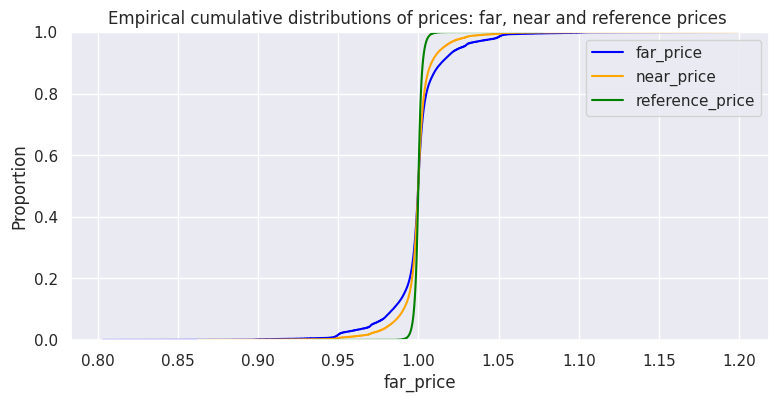

In [11]:
sns.set(rc = {'figure.figsize': (9,4)})
sns.ecdfplot(data = df.query("far_price < 1.2 & far_price >  .8"), x = 'far_price', color = 'blue', label = 'far_price' )
sns.ecdfplot(data = df.query("near_price < 1.2 & near_price > .8"), x = 'near_price', color = 'orange', label = 'near_price')
sns.ecdfplot(data = df.query("reference_price < 1.2 & reference_price > .8"), x = 'reference_price', color = 'green', label = 'reference_price')
plt.title("Empirical cumulative distributions of prices: far, near and reference prices ")
plt.legend()

### considerations:
* the *far_price*, which is based on the auction only, is by far the most variable. So it may be important to consider it. 
* the *reference_price*, based on order book only, is the less variable
* the *near_price*, which considers both auction and order book data, is midway in terms of variability, but it's closer to the *far_price* in the distribution. Along with the *far_price*, the dataset contains many nans: the missing values imputation strategy will be crucial.

### Some data grouped by day

variable imbalance_size


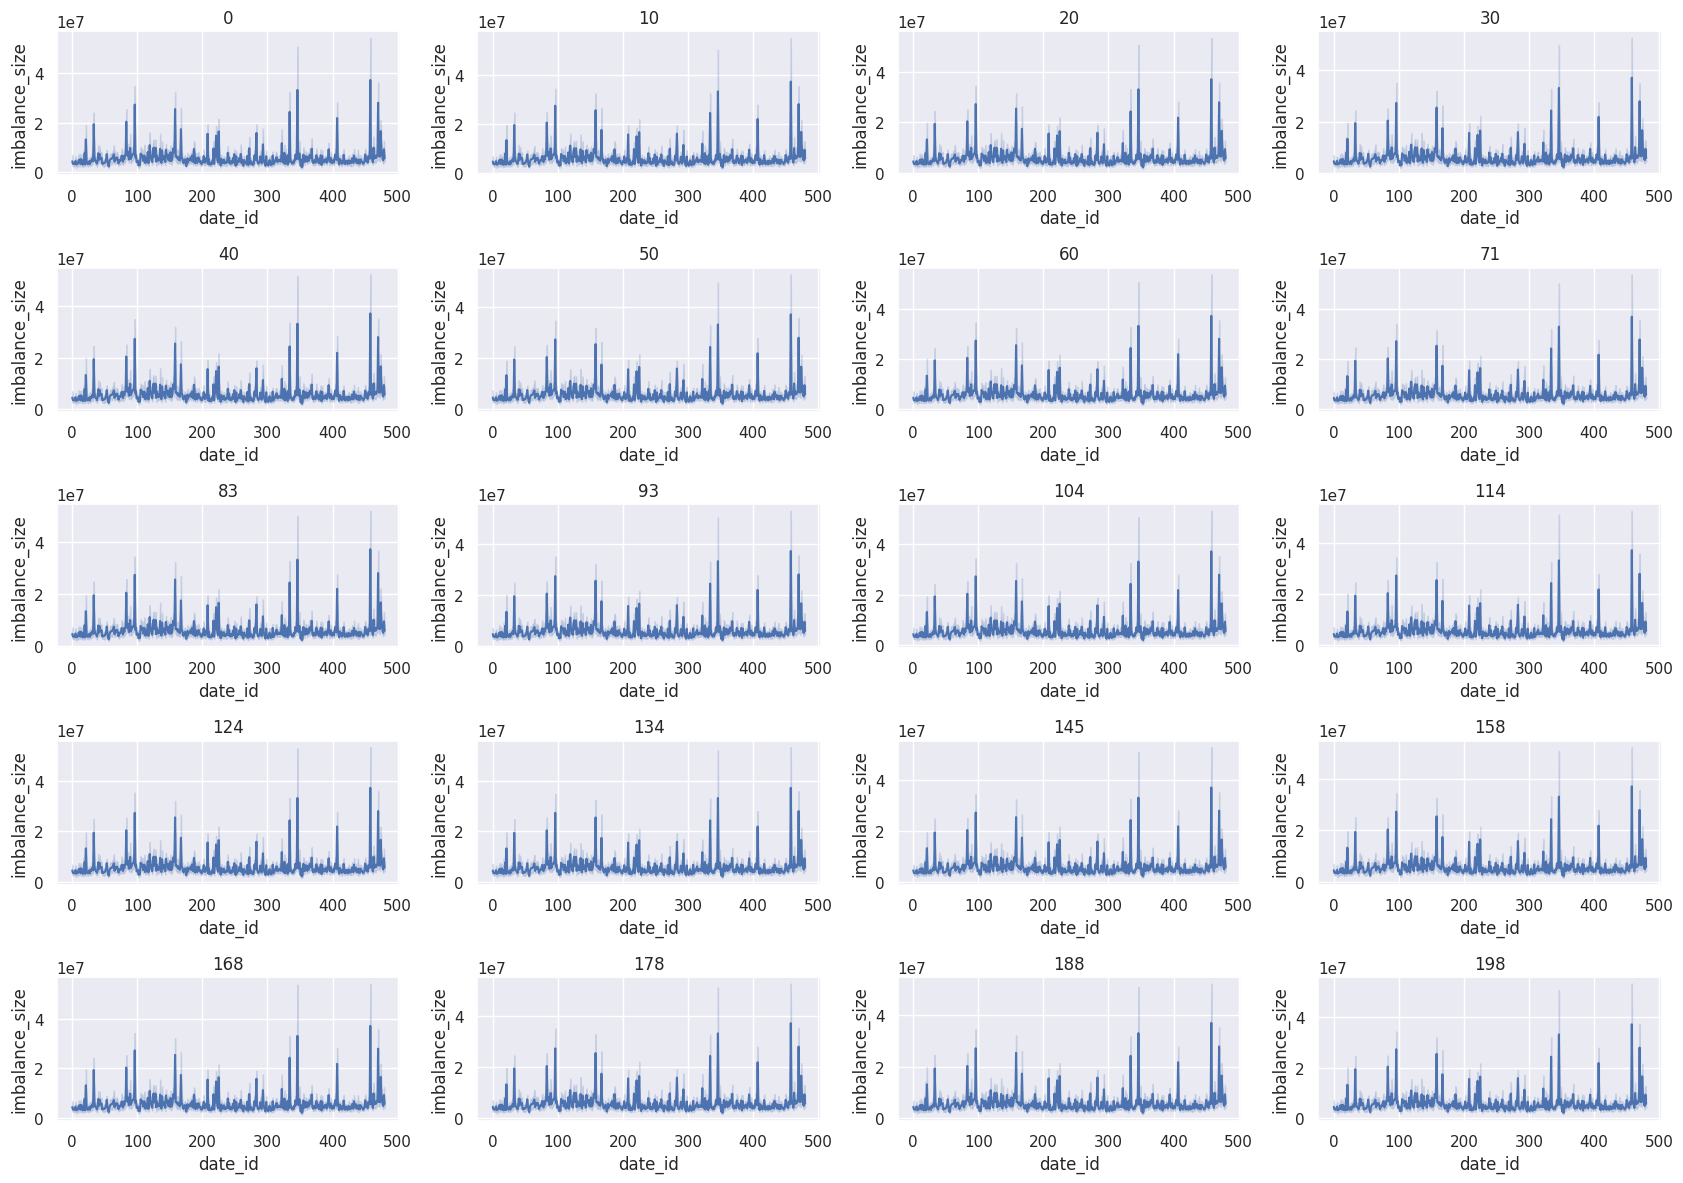

variable imbalance_buy_sell_flag


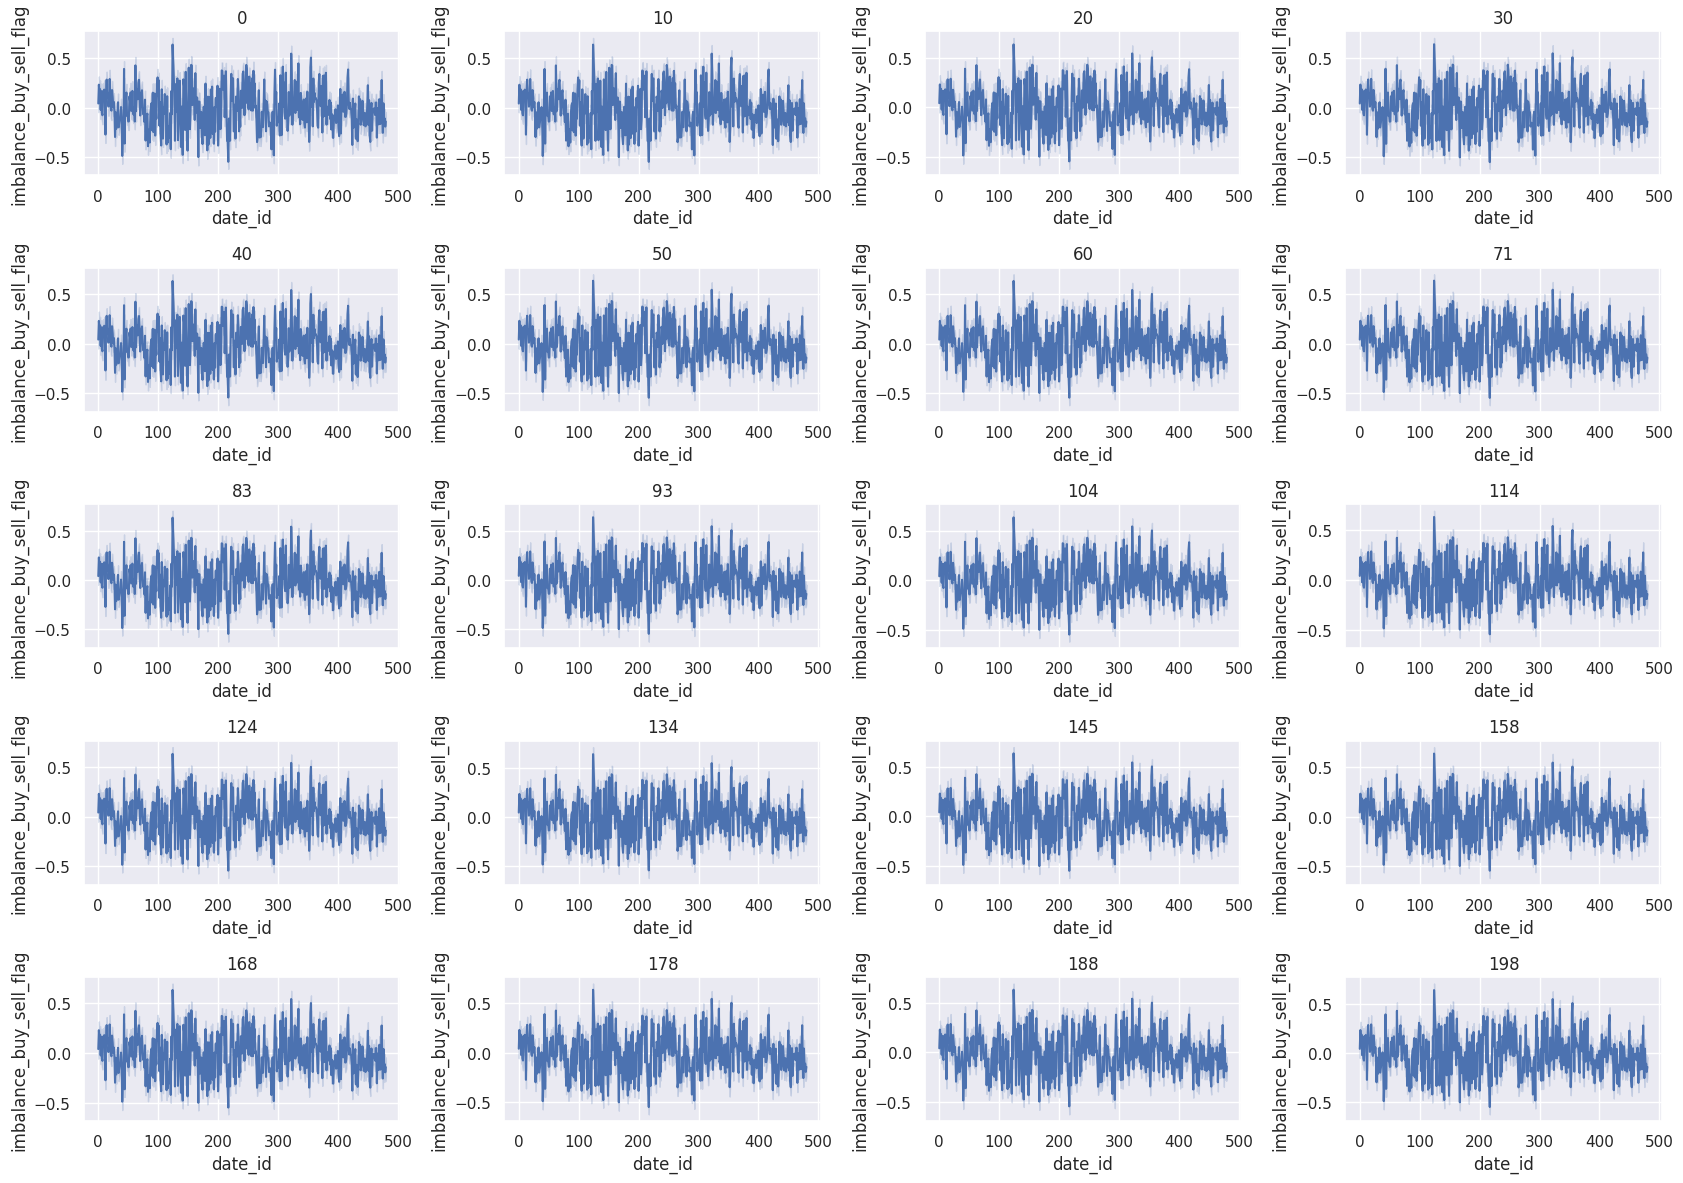

variable reference_price


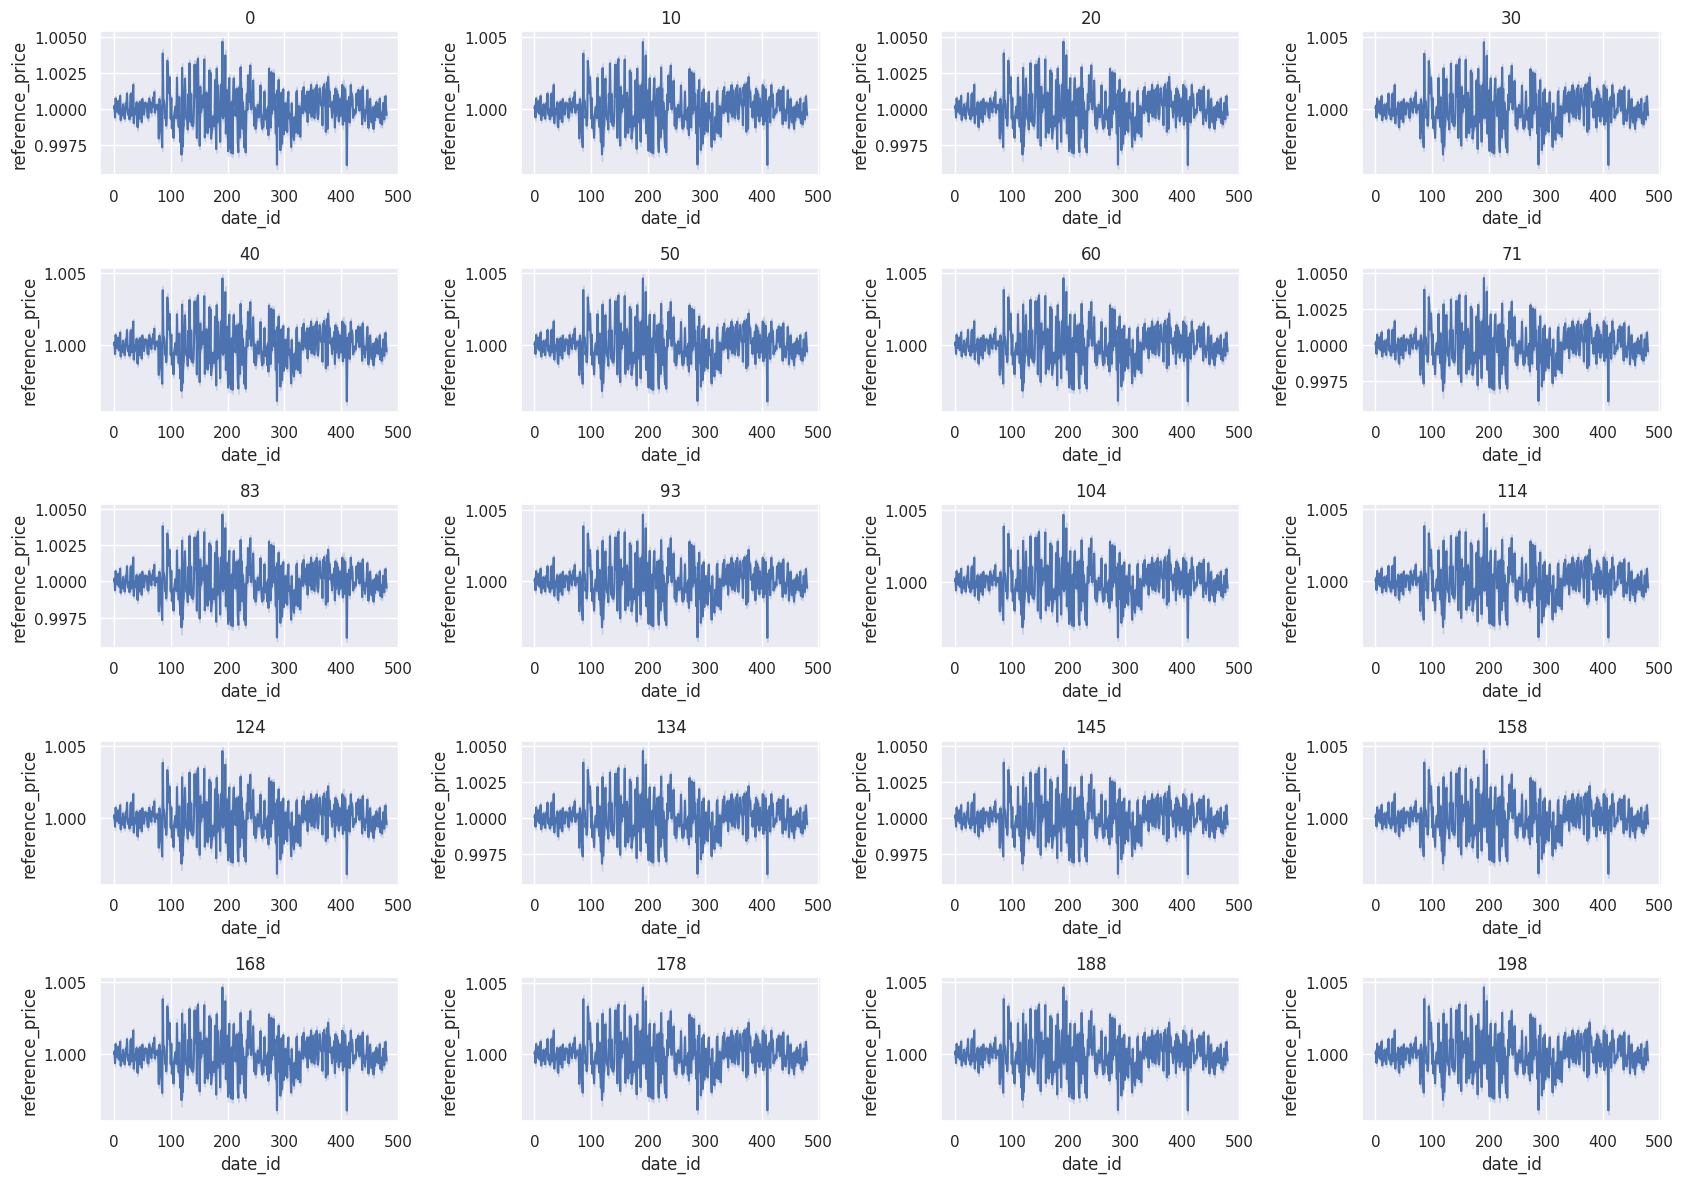

variable matched_size


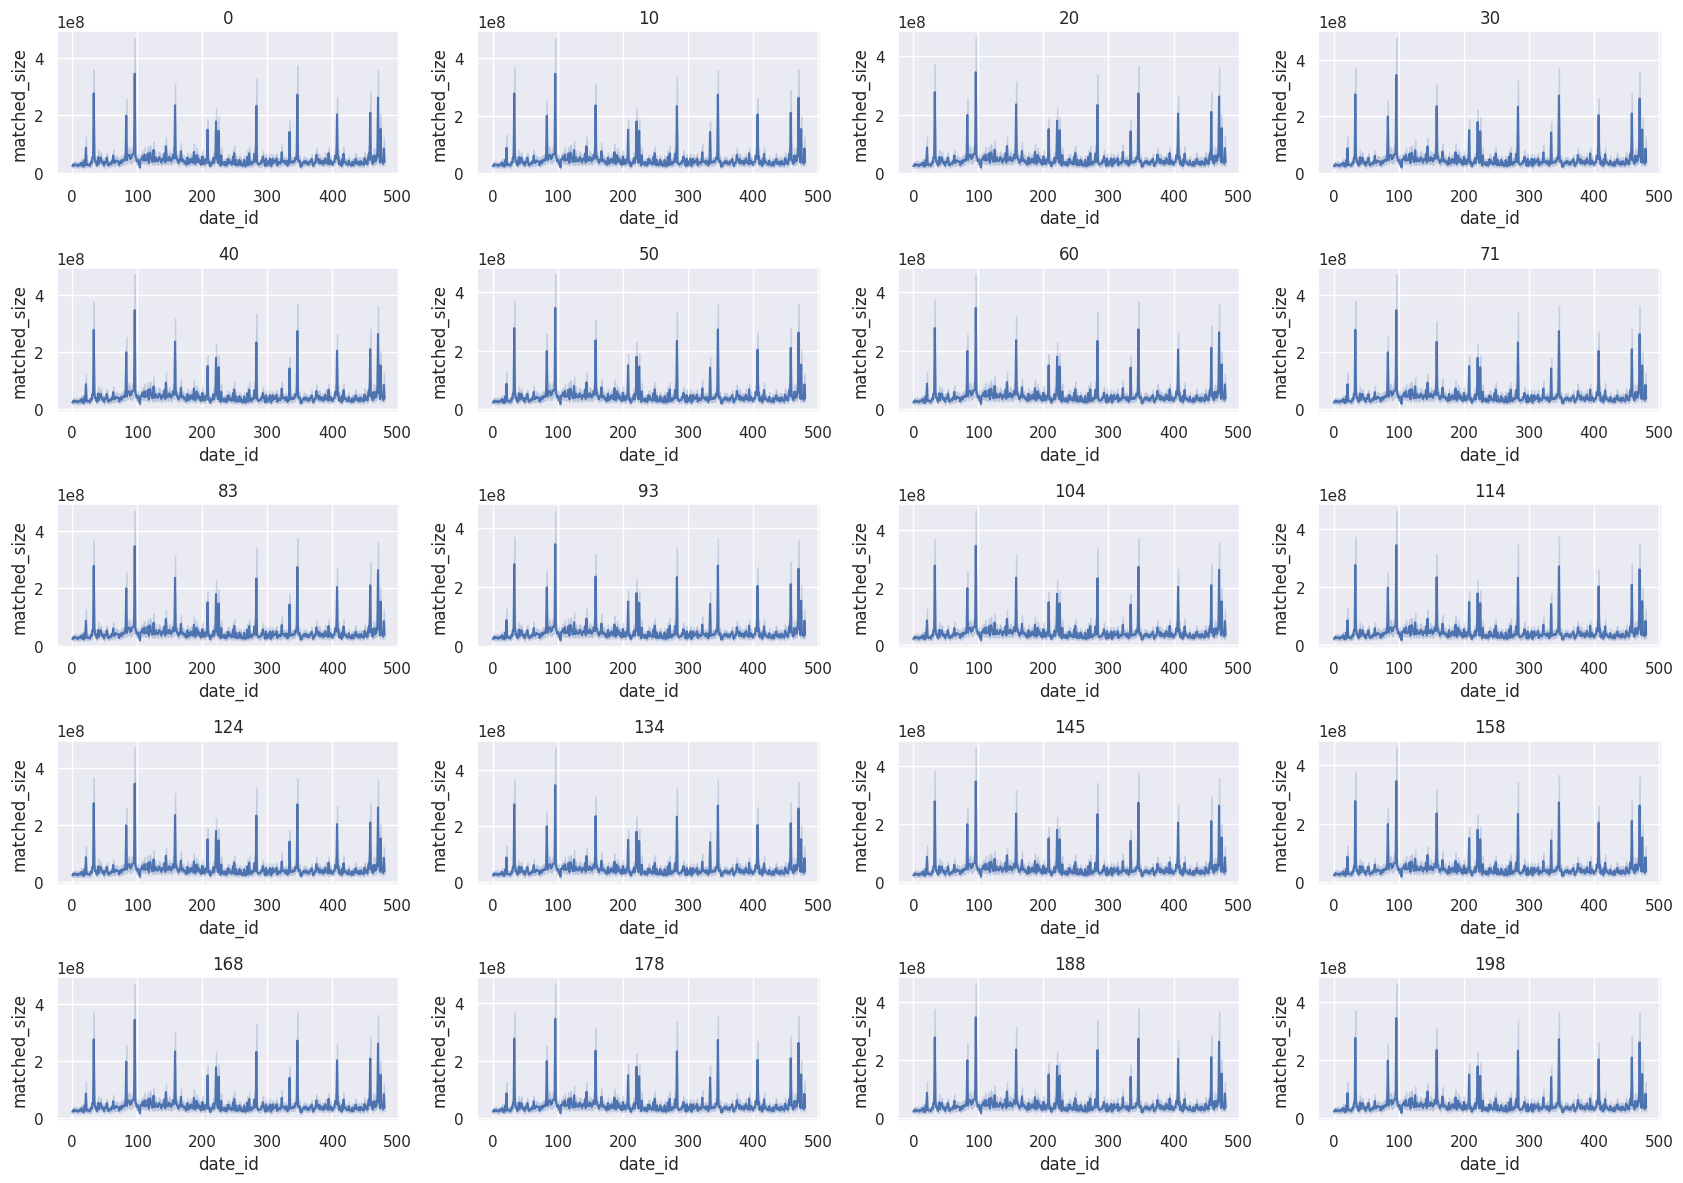

variable far_price


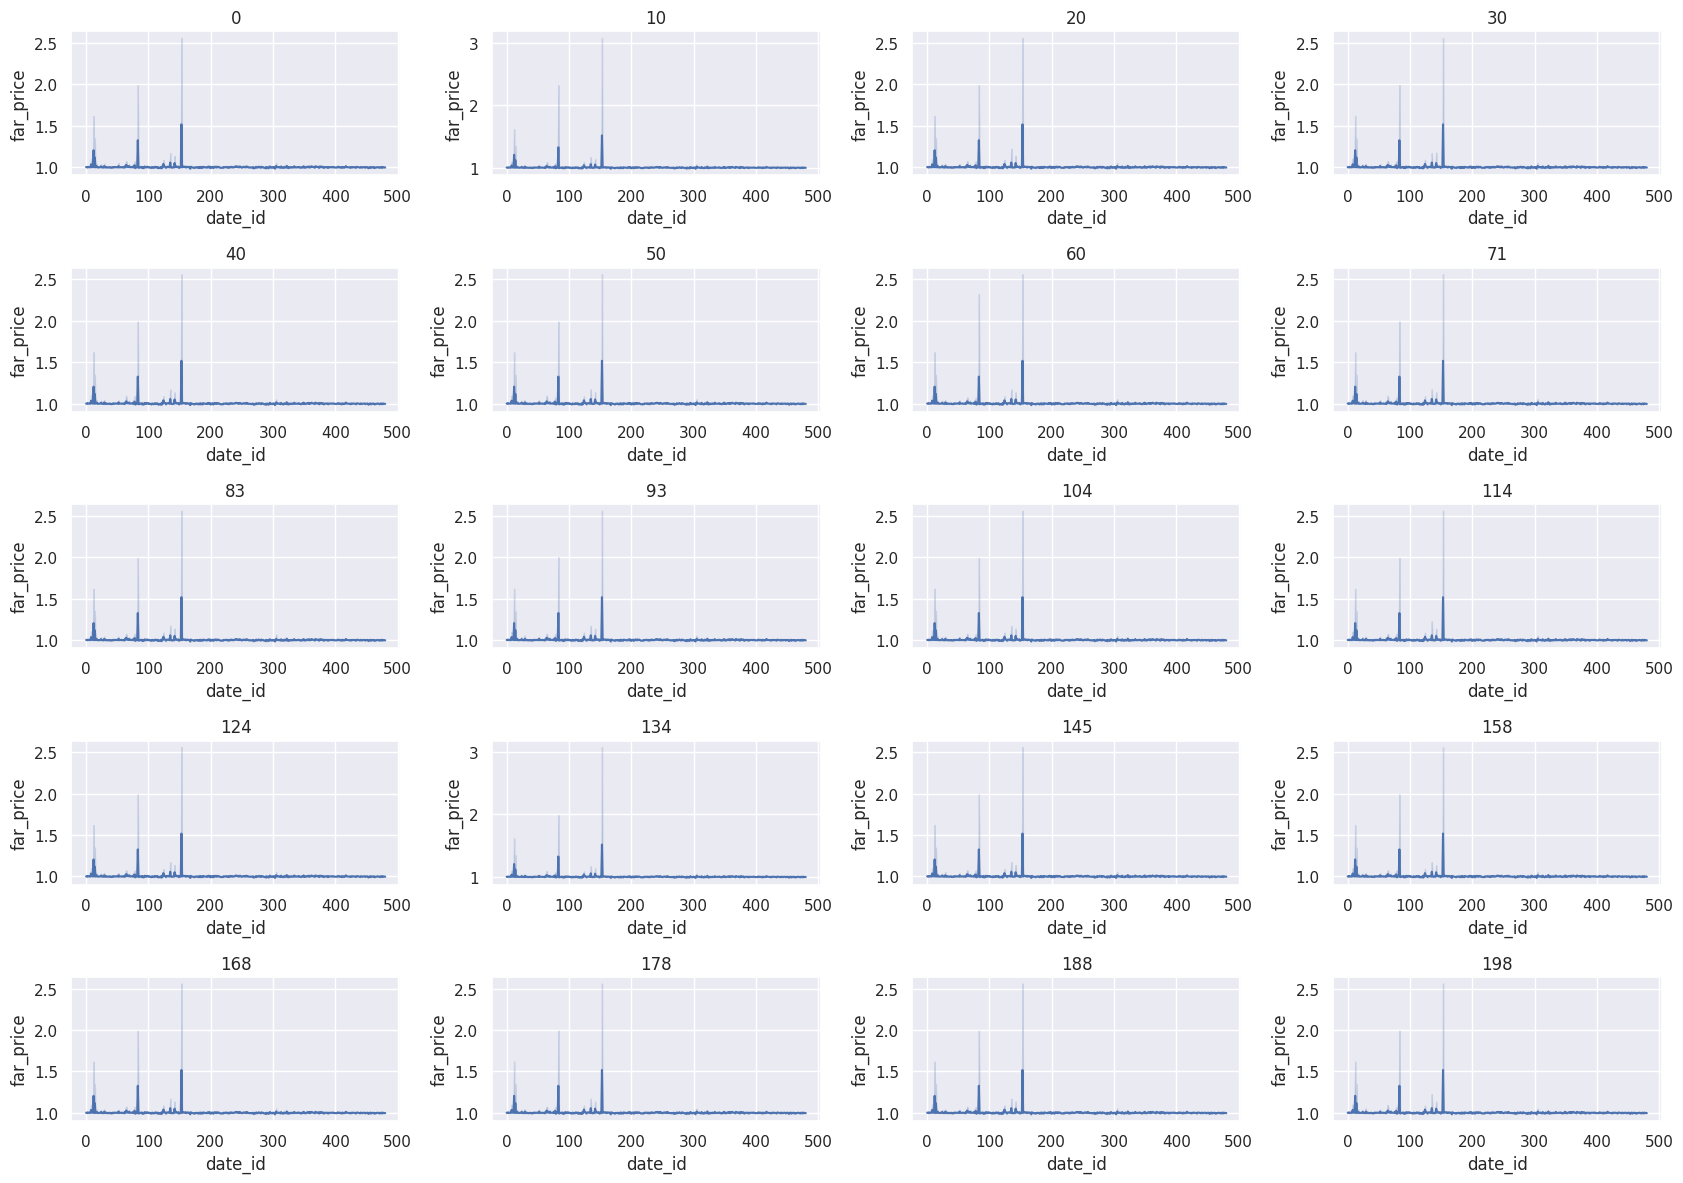

variable near_price


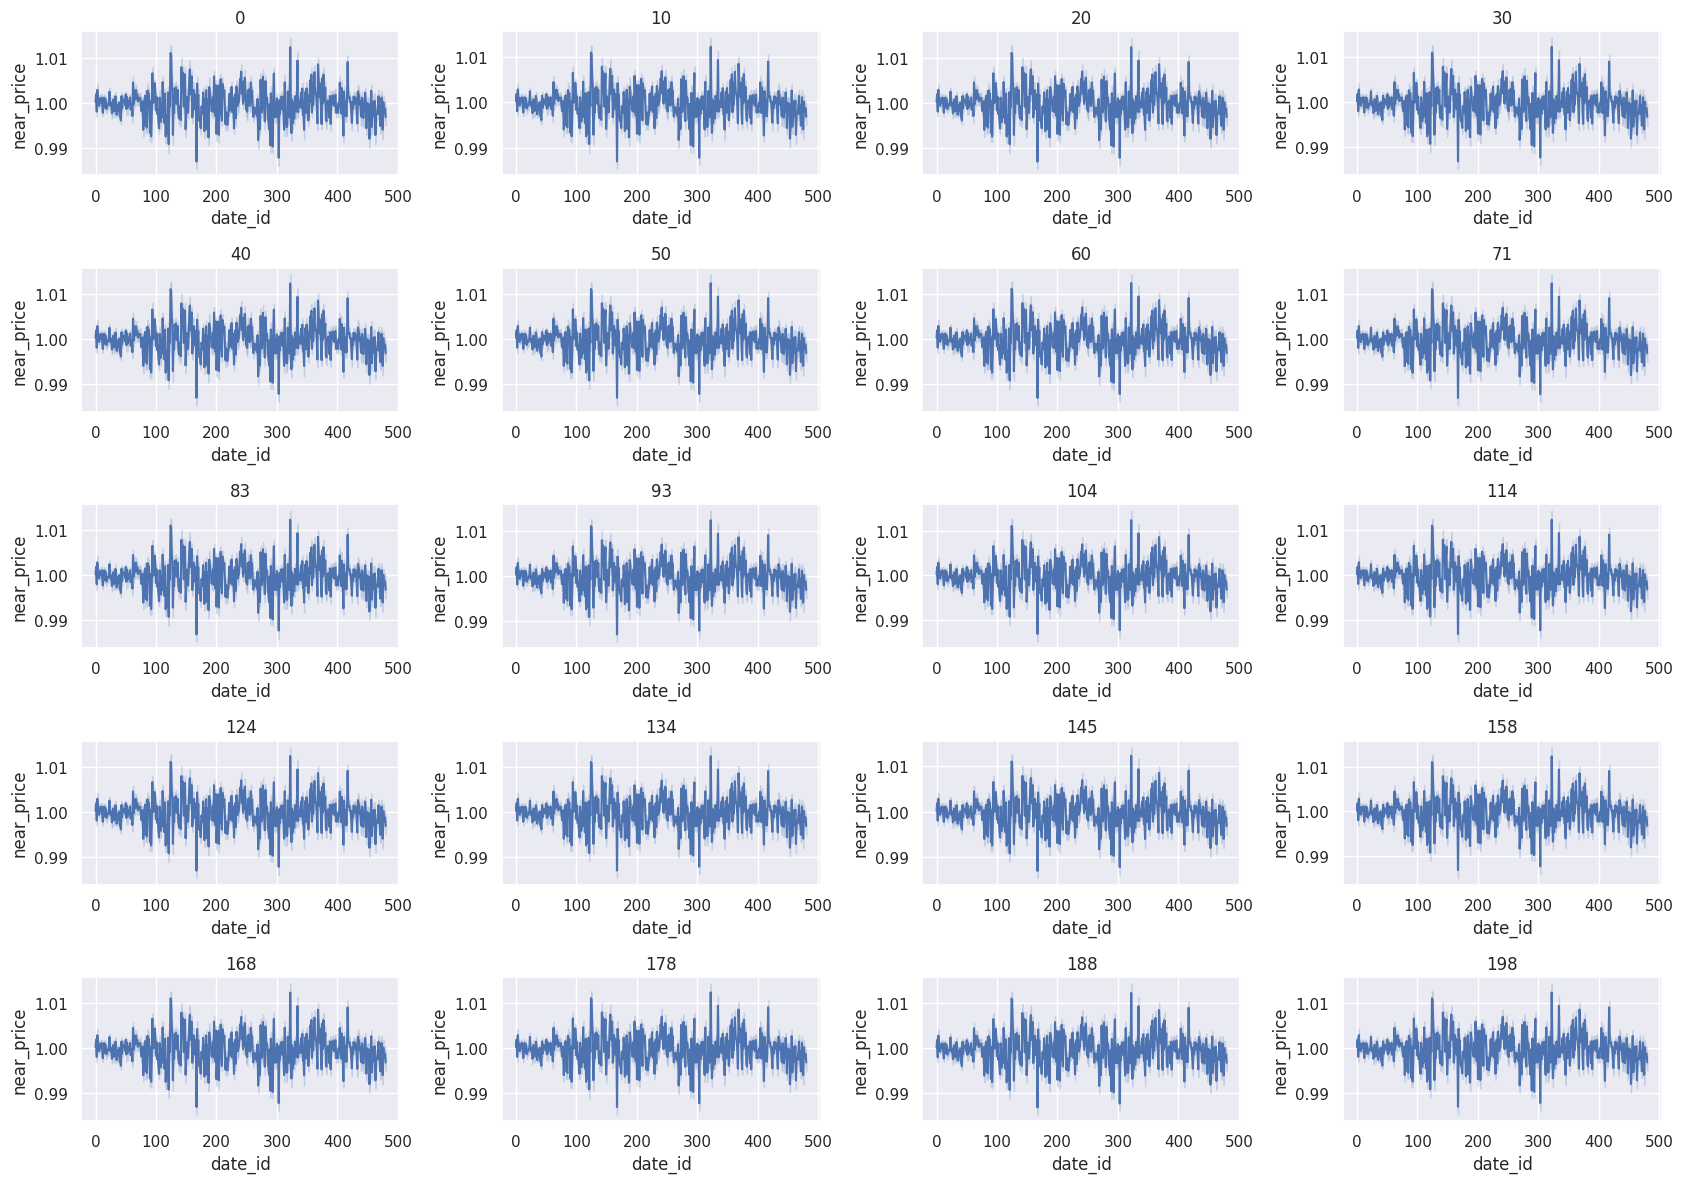

variable bid_price


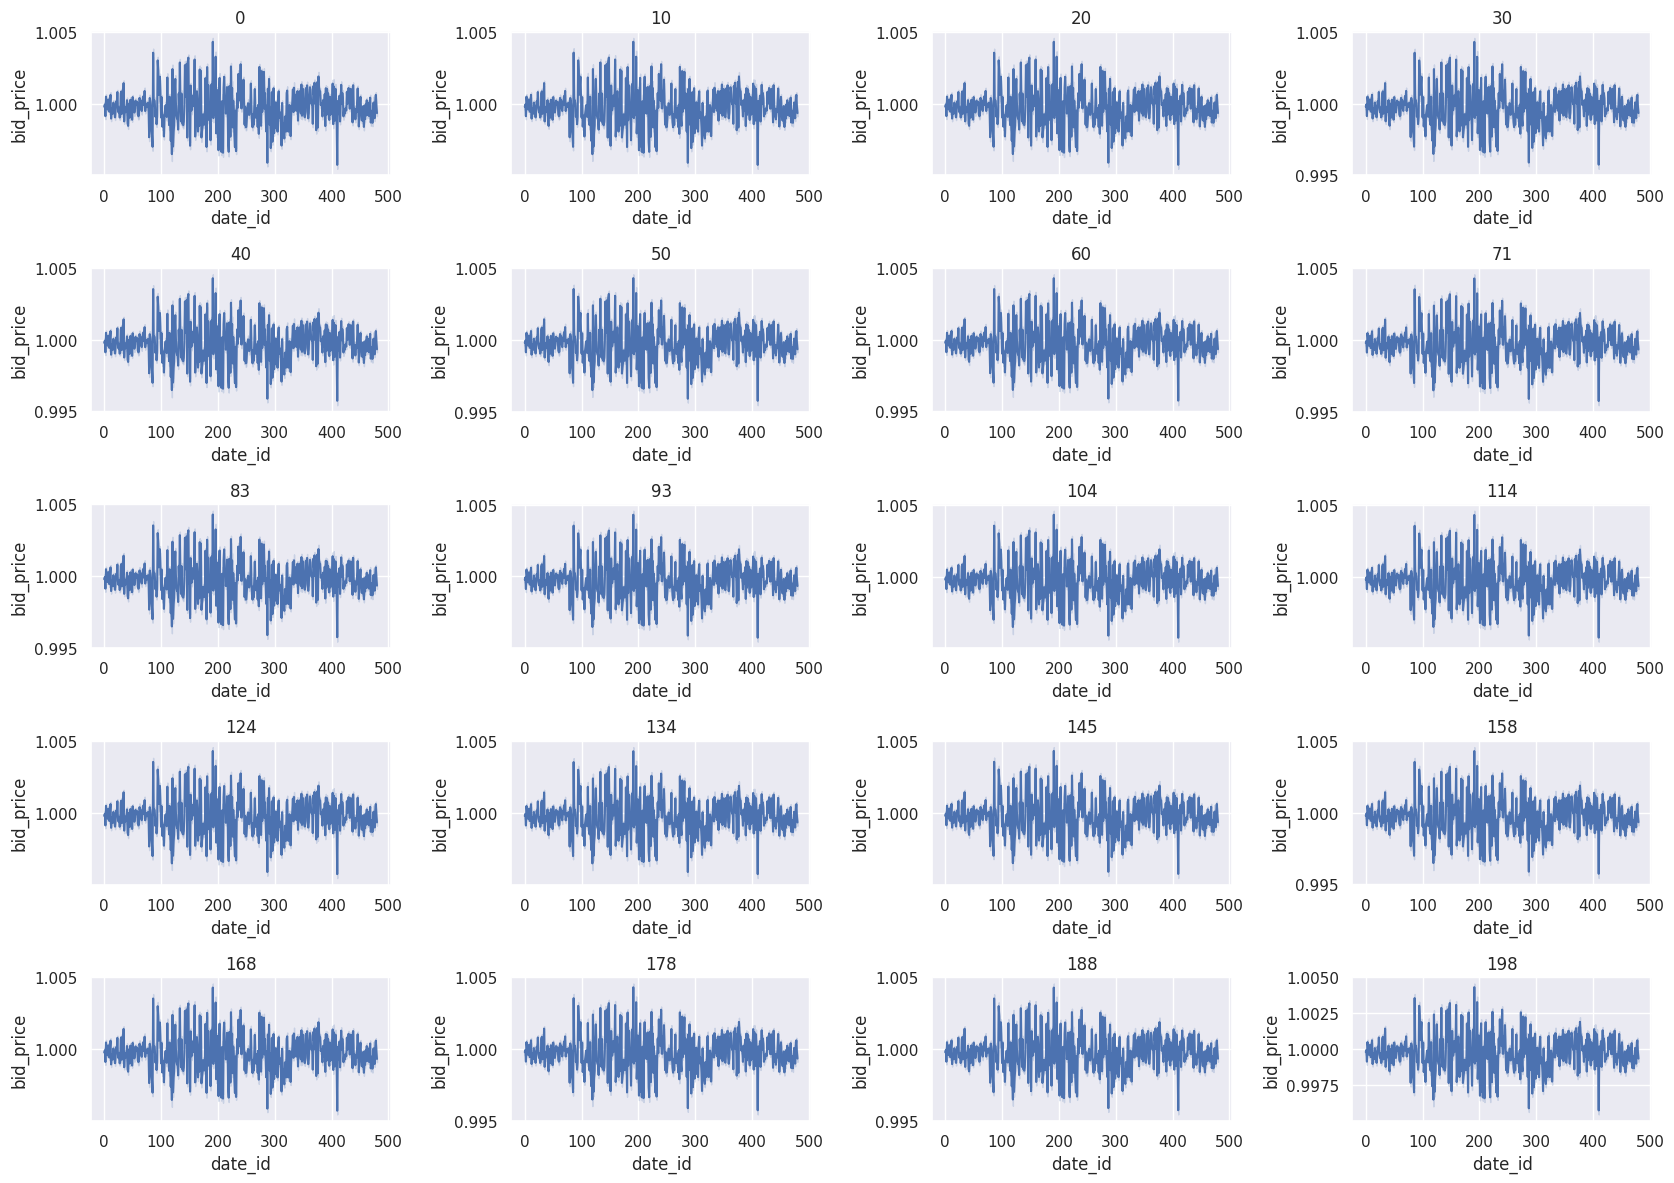

variable bid_size


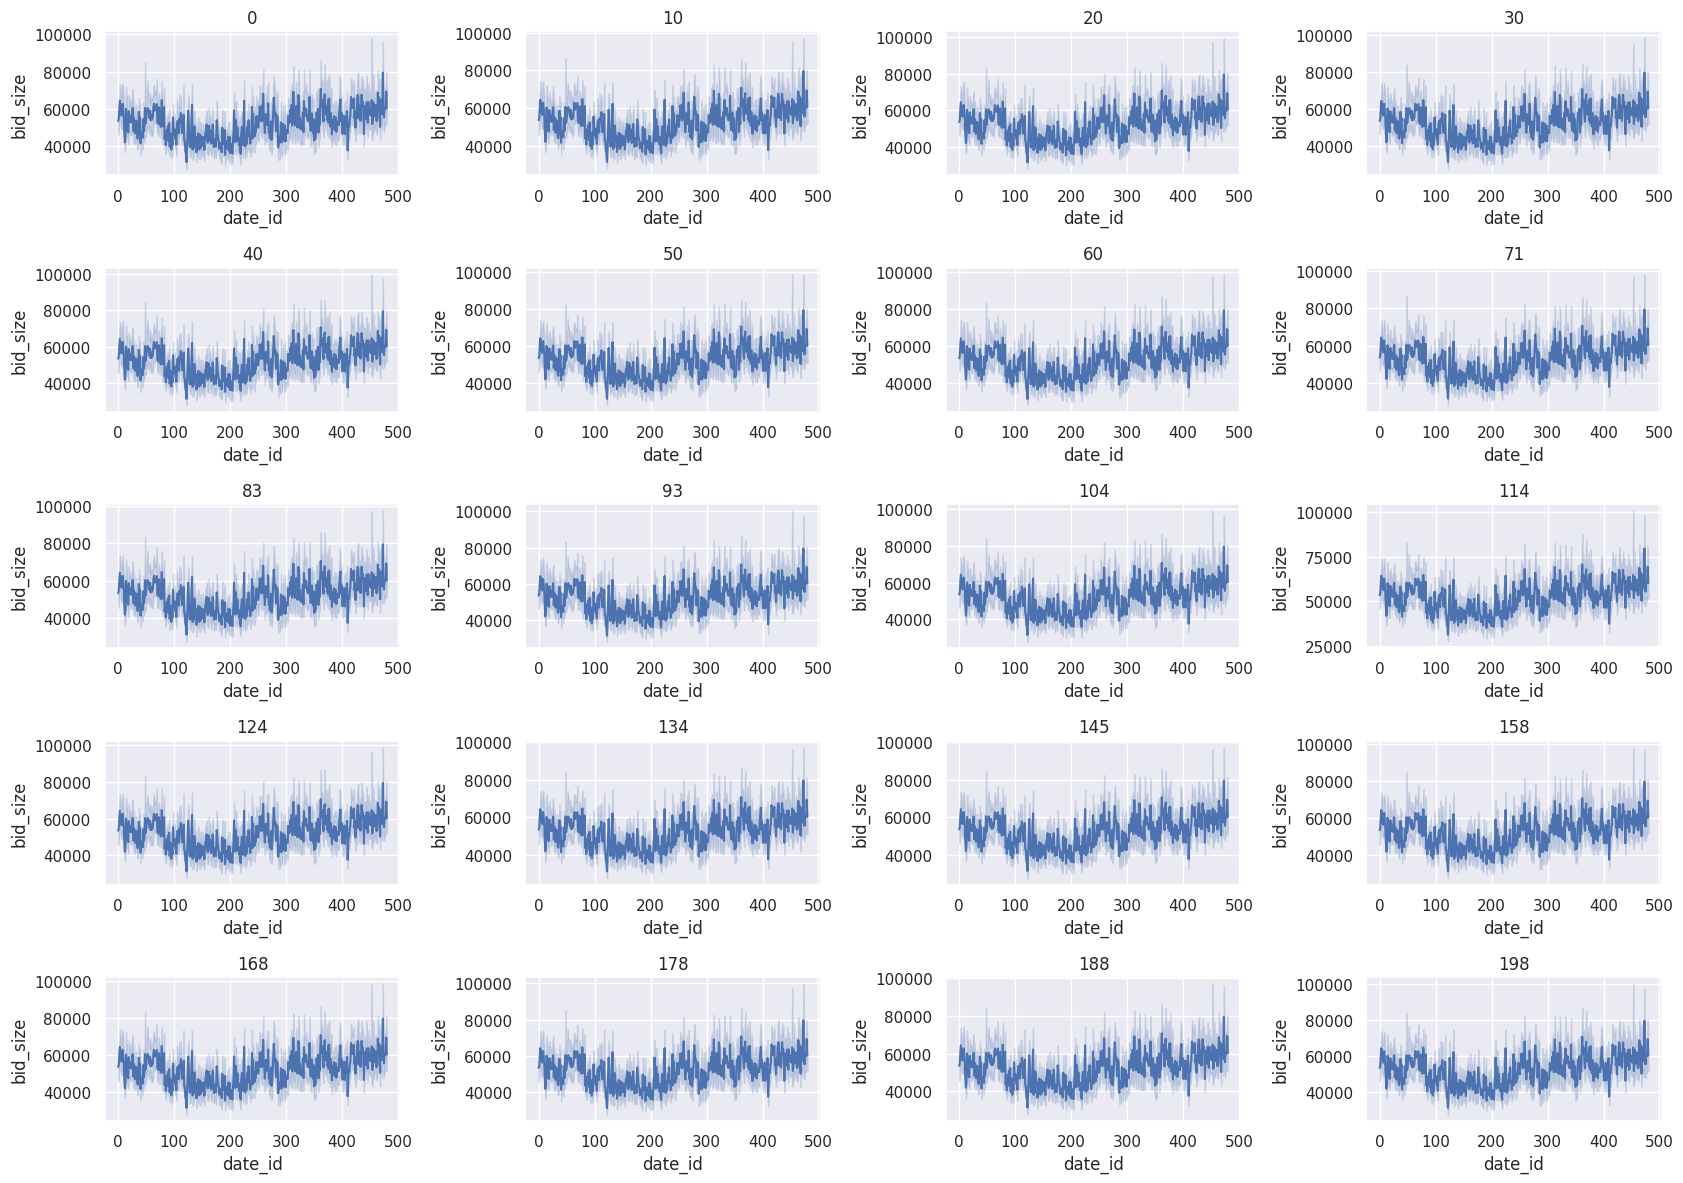

variable ask_price


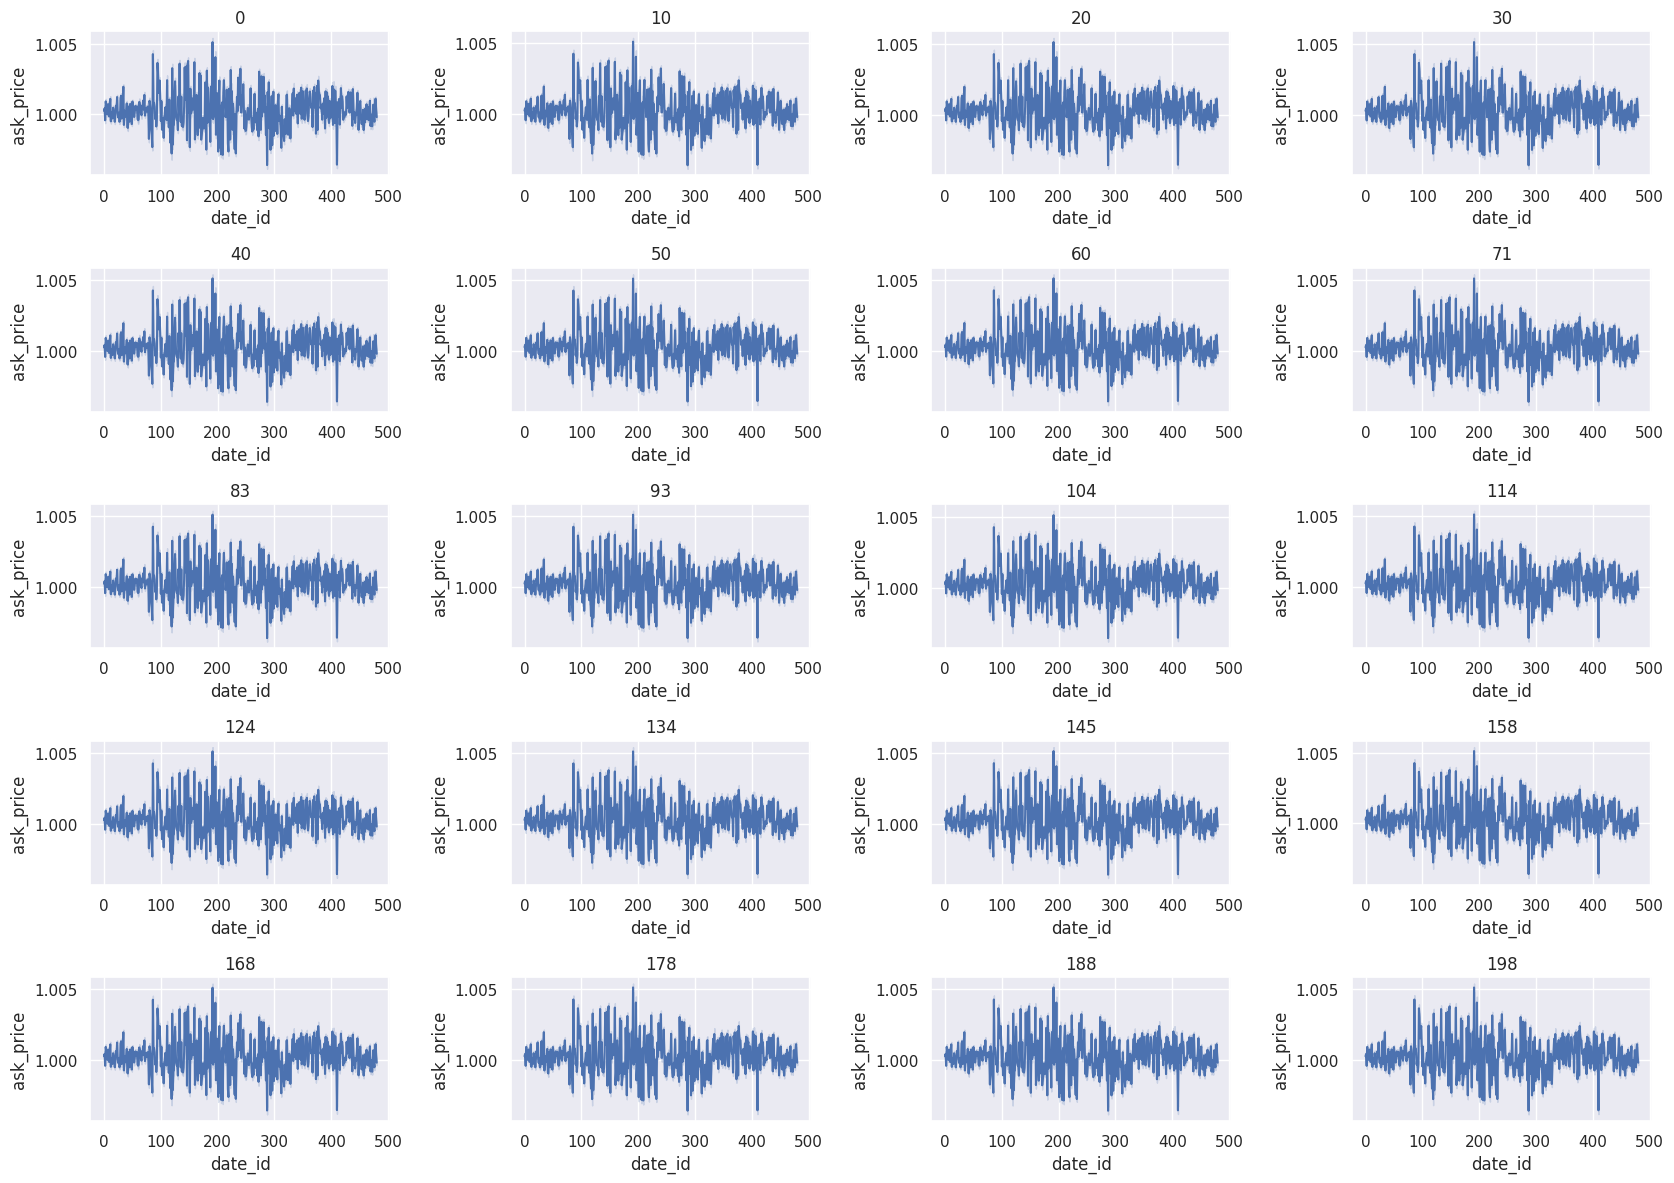

variable ask_size


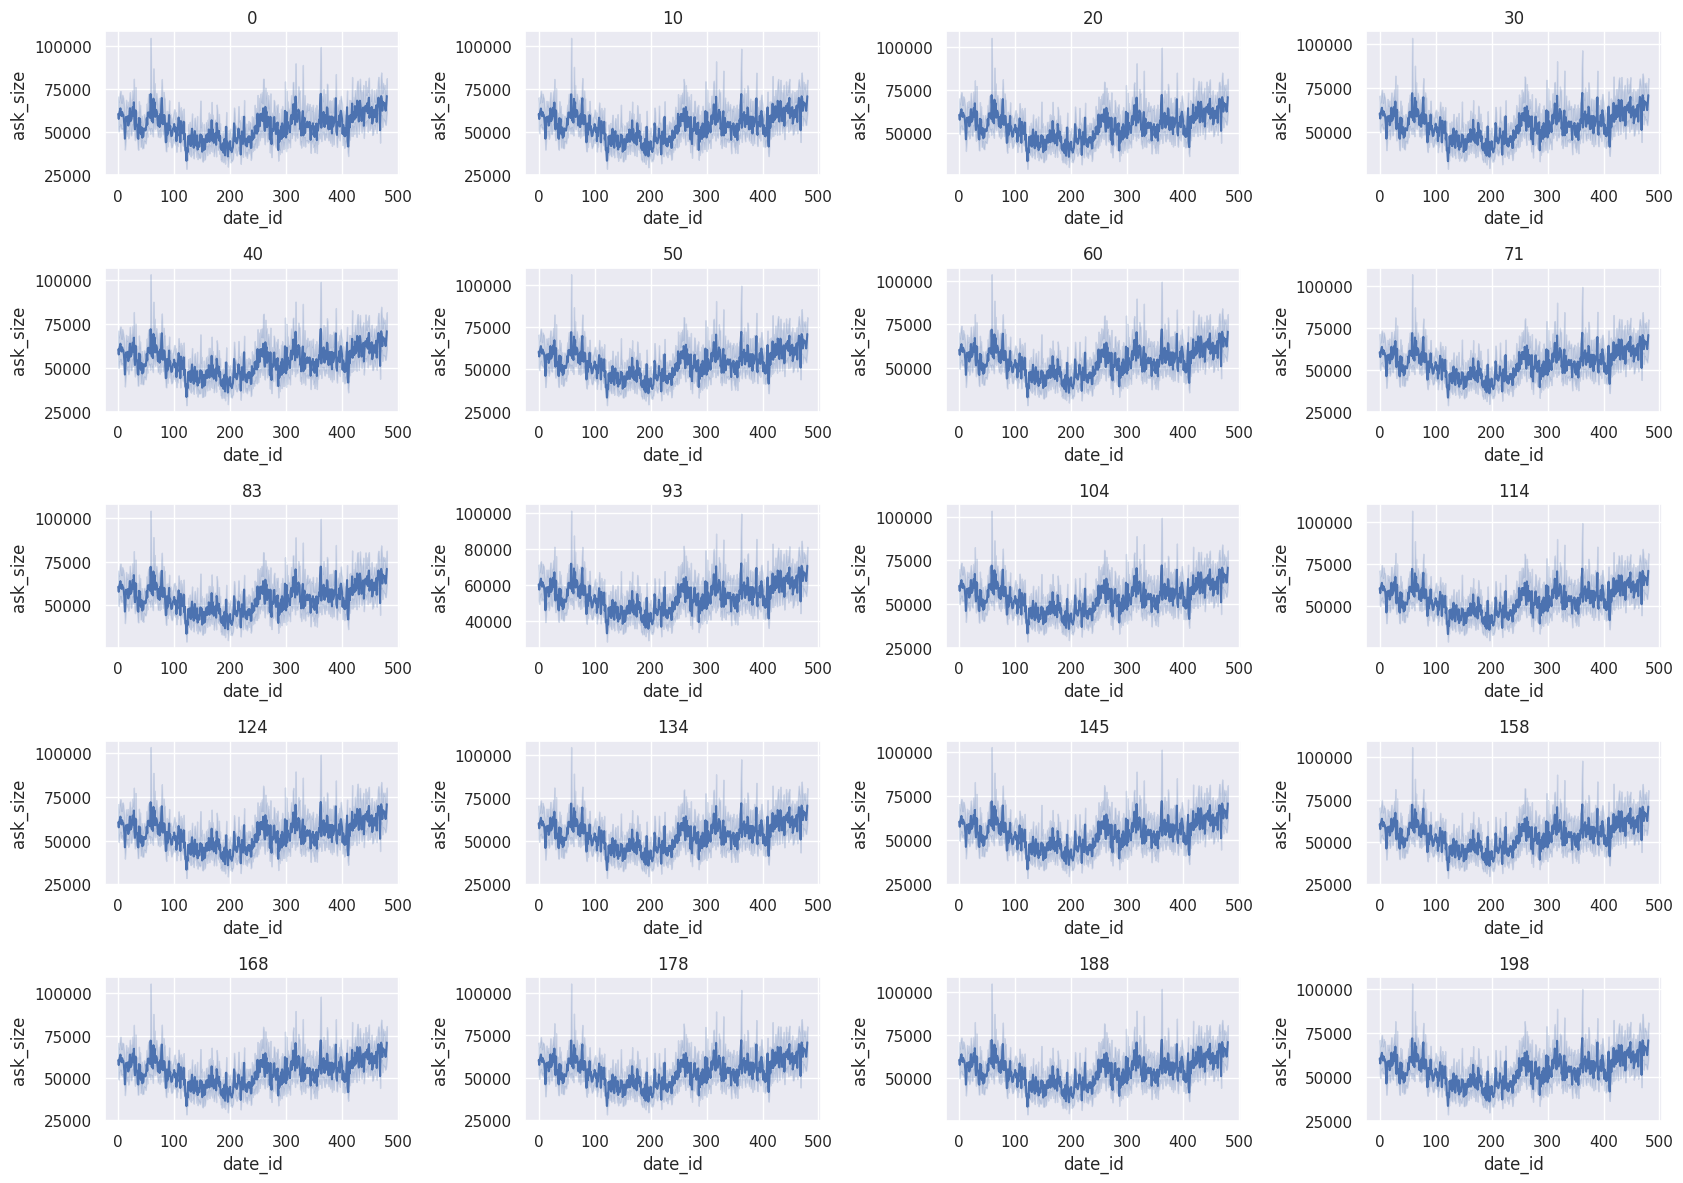

variable wap


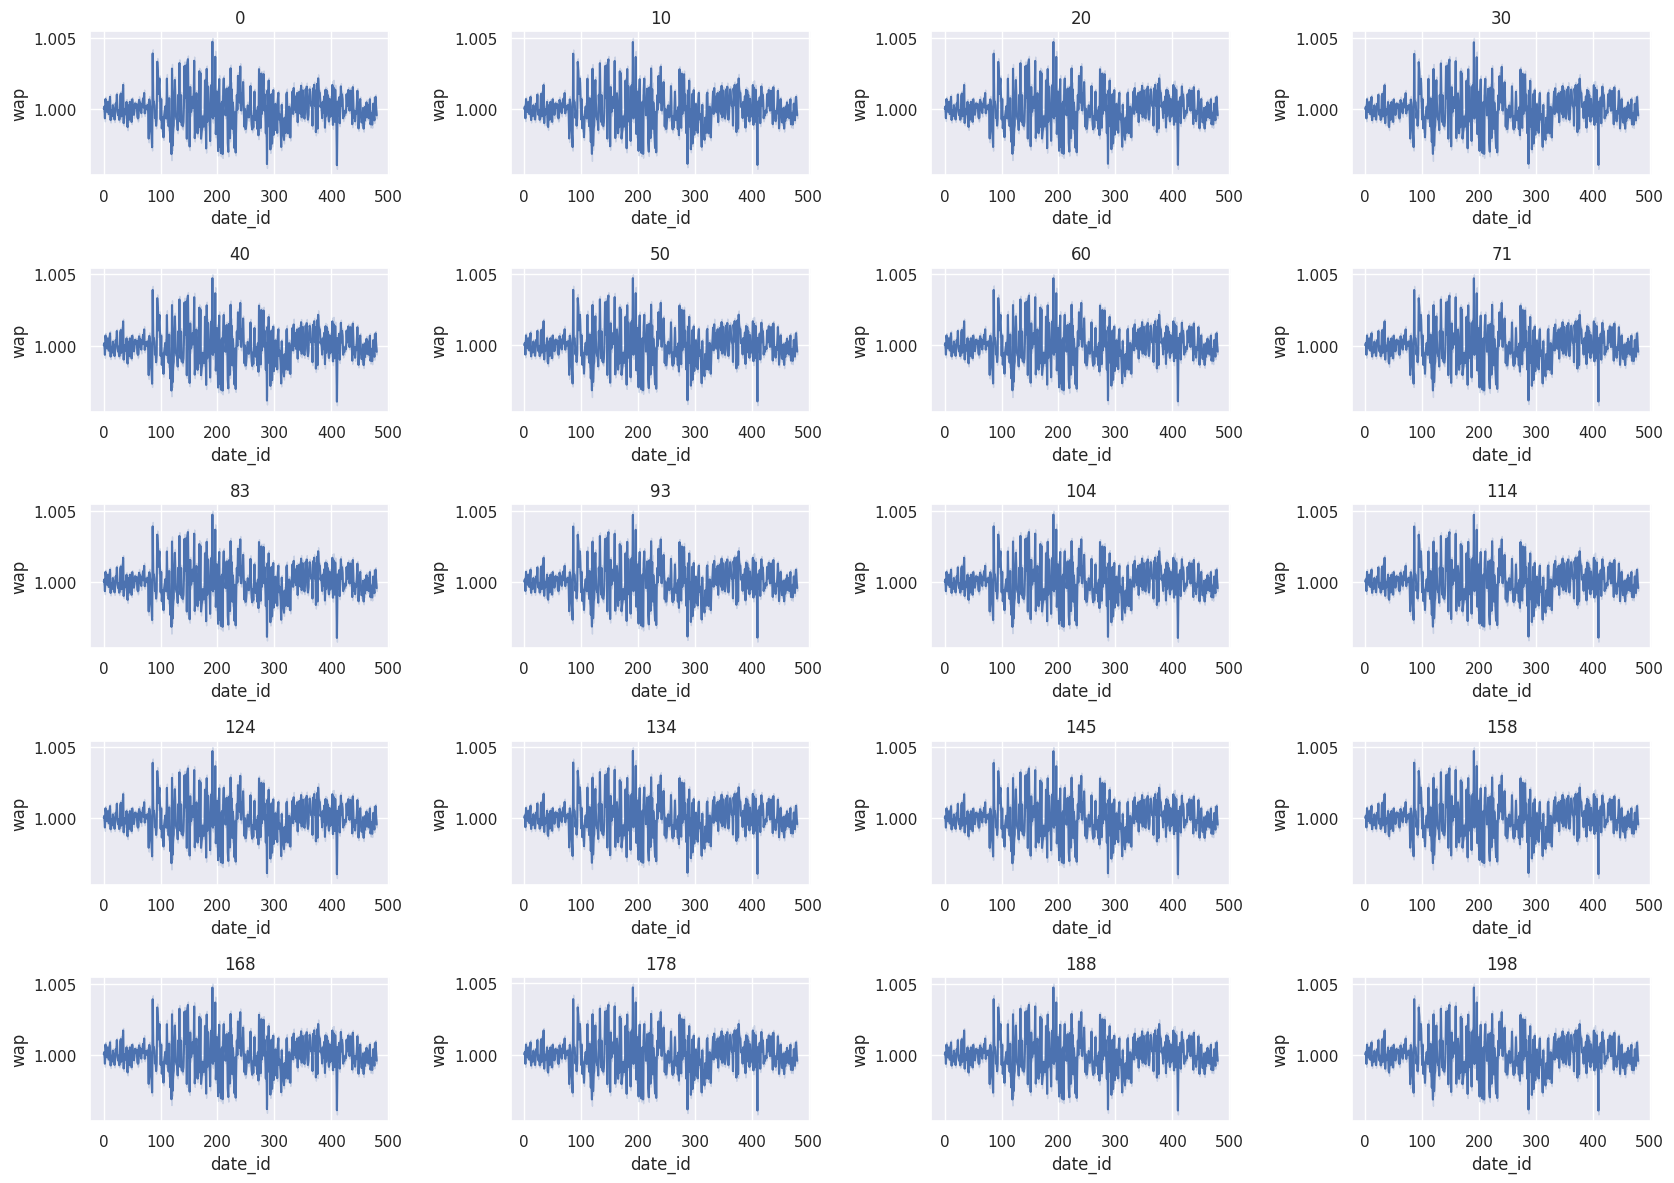

variable target


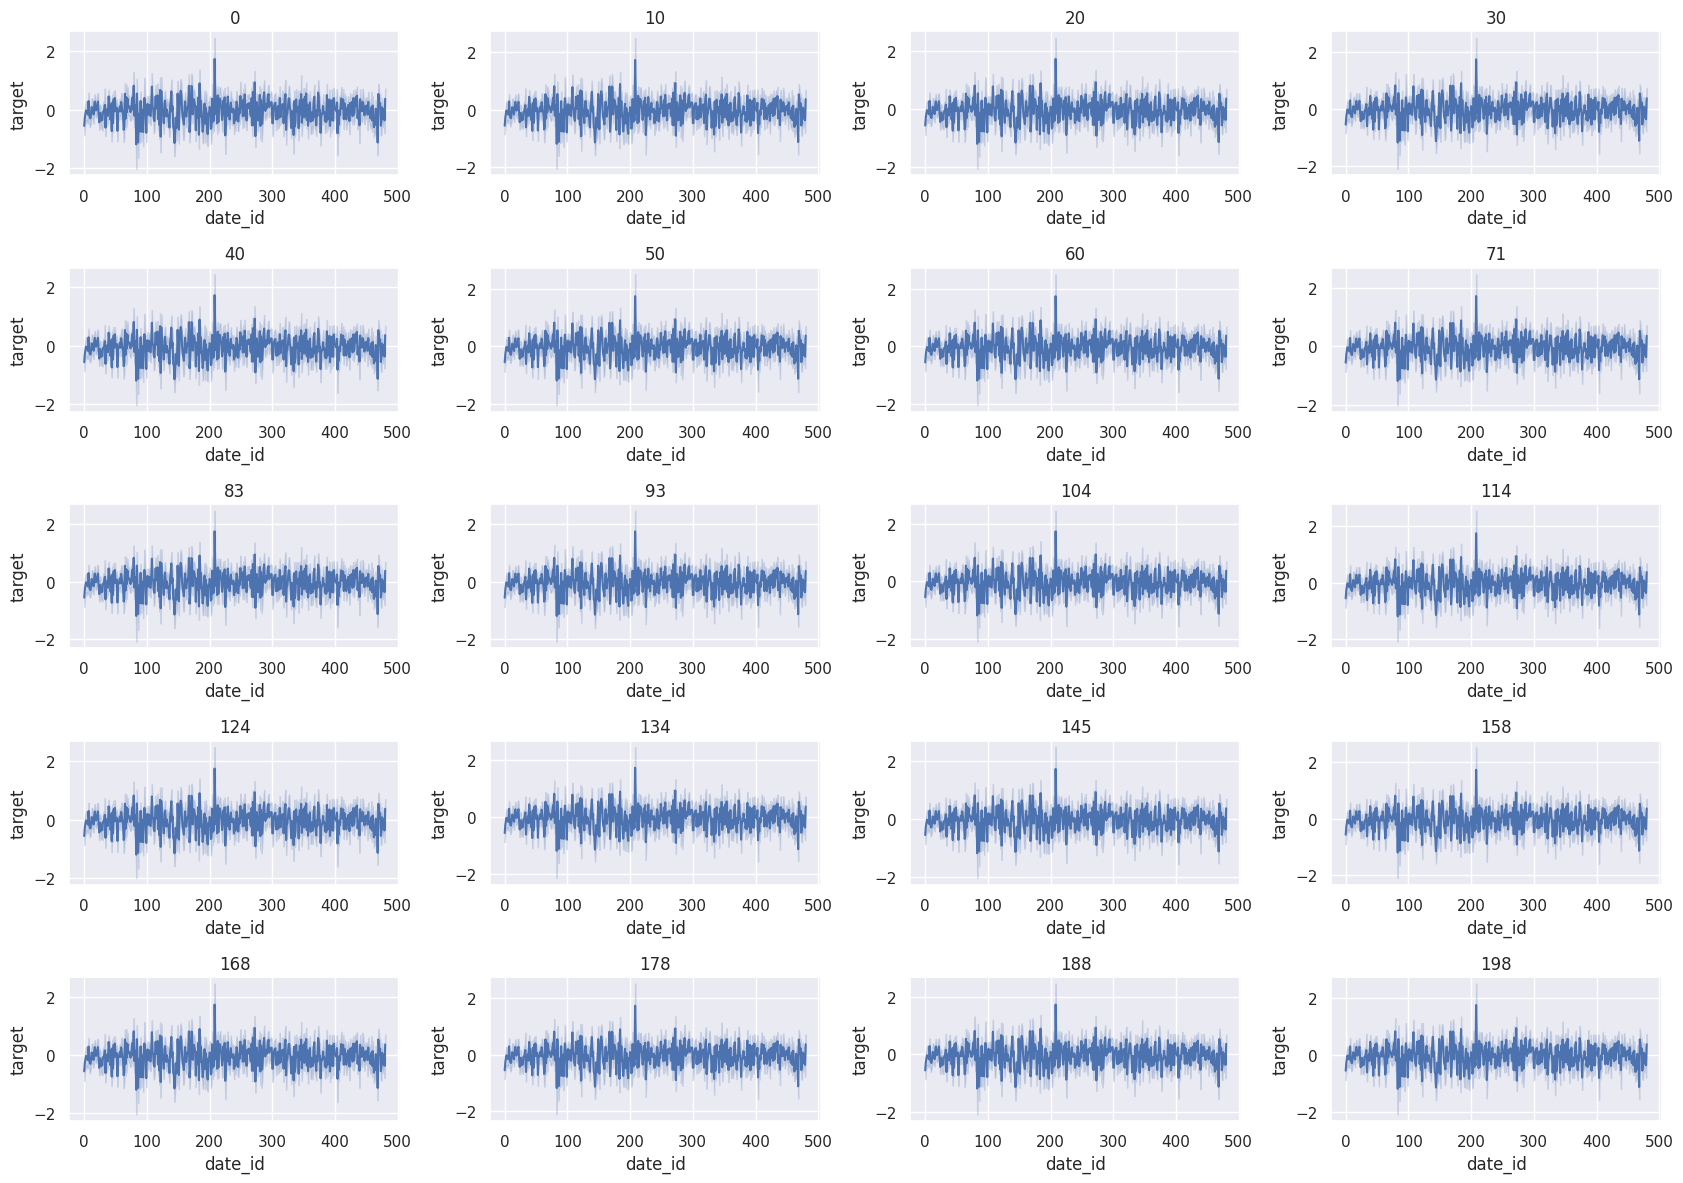

In [12]:
_ = df.groupby(['date_id', 'stock_id'])[cols_to_plot].mean().reset_index()
for col in cols_to_plot:
    fig, axes = plt.subplots(5, 4, figsize = (17, 12) )
    stocks = _.stock_id.unique()
    print(f"variable {col}")
    for i, stock in enumerate(stocks):
        if i % 10 == 0: #200 unique stocks
            ax = axes[i // 10 // 4, i // 10 % 4]        
            sns.lineplot(data = _, x = 'date_id', y = col, ax = ax)
            ax.set_title(f'{stock}')
    plt.tight_layout()
    plt.show()


## Add a feature, which is the weighted average wap of all the stocks
For each day and time instant, I want to calculate: sum(wap * (bidsize + asksize))/sum(bidsize + asksize)

In [13]:
def compute_w_a_wap(wap, ask_size, bid_size):
    return (wap * (bid_size + ask_size)).sum() / (bid_size + ask_size).sum()

df_wa_wap = df.groupby(['date_id', 'seconds_in_bucket']).apply(lambda x : compute_w_a_wap(x.wap, x.ask_size, x.bid_size))\
    .reset_index().rename(columns = {0 : 'w_a_wap'})

df_wa_wap.head()

date_id  seconds_in_bucket   w_a_wap
0        0                  0  1.000000
1        0                 10  1.000351
2        0                 20  1.000539
3        0                 30  1.000415
4        0                 40  1.000504

## Then, I subtract it to the wap of each entry, obtaining a metric which is neutral with respect to the overall market movement

In [14]:
df = df\
    .merge(df_wa_wap, on = ['date_id', 'seconds_in_bucket'], validate = 'm:1')\
    .assign(wap_less_wawap = lambda df_ : (df_.wap - df_.w_a_wap) * 10000)

In [15]:
cols_to_plot = ['imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'w_a_wap', 'wap_less_wawap']

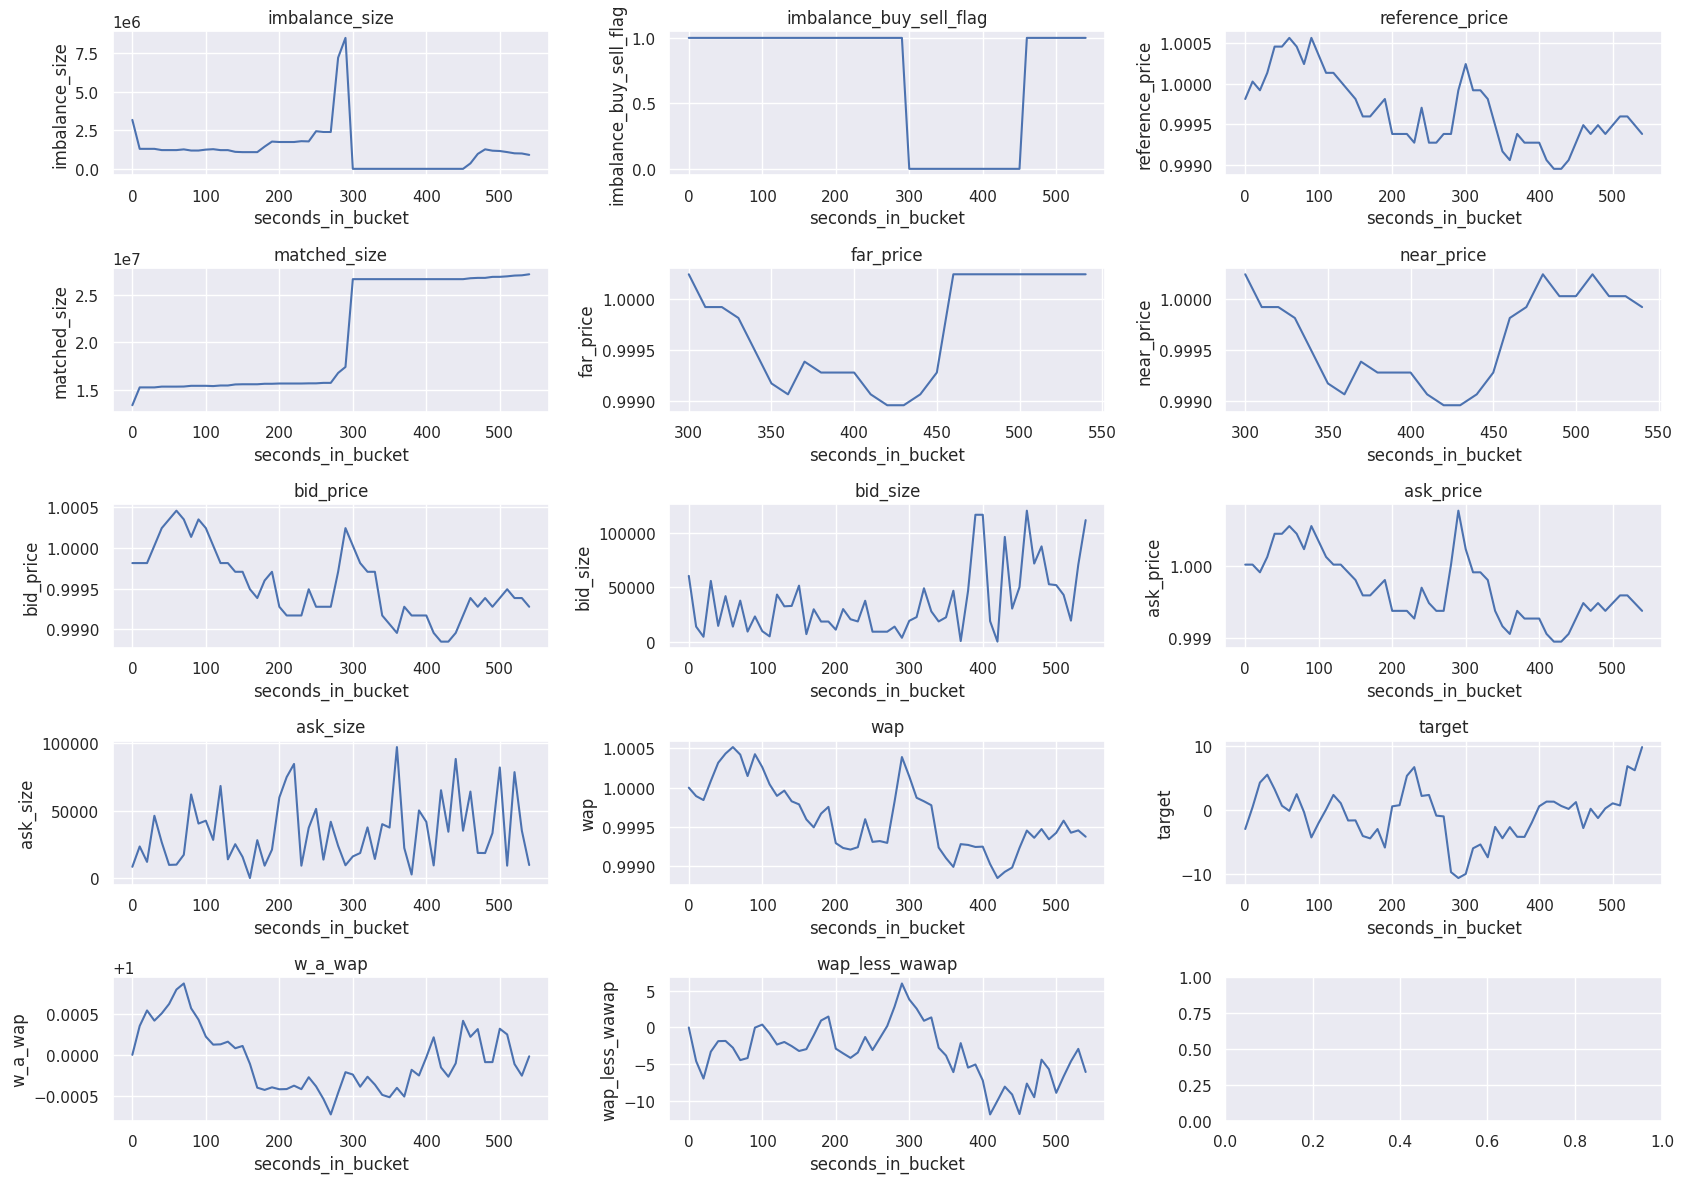

In [16]:
fig, axes = plt.subplots(5, 3, figsize = (17, 12))
_ = df.query("stock_id == 0 & date_id == 0")
for i, col in enumerate(cols_to_plot):
    ax = axes[i // 3, i % 3 ]
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

## plotting randomly the time series of the target and the newly created feature

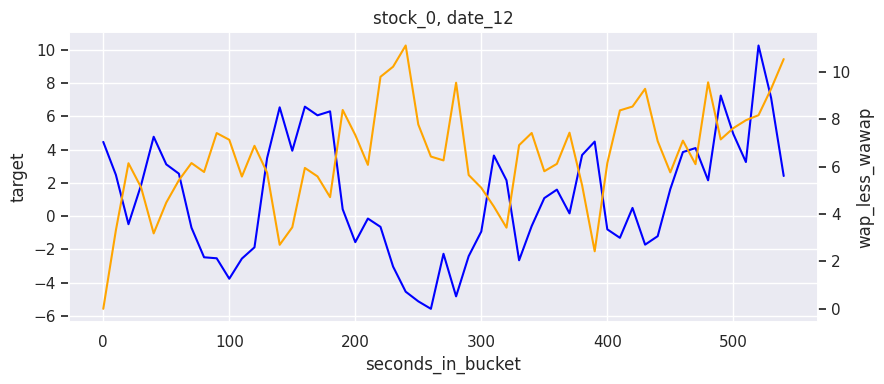

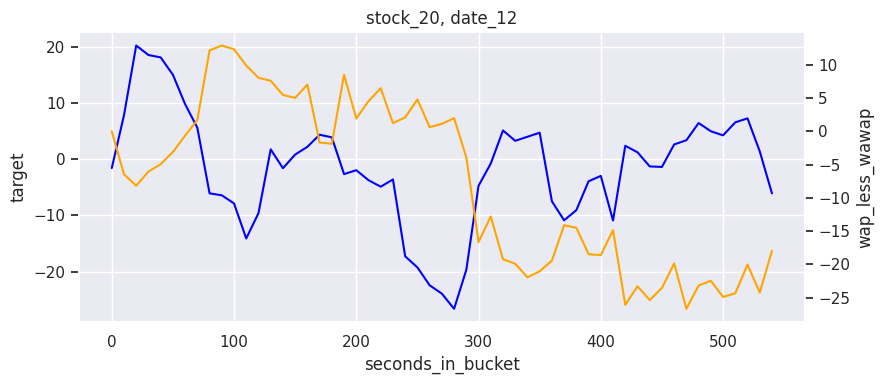

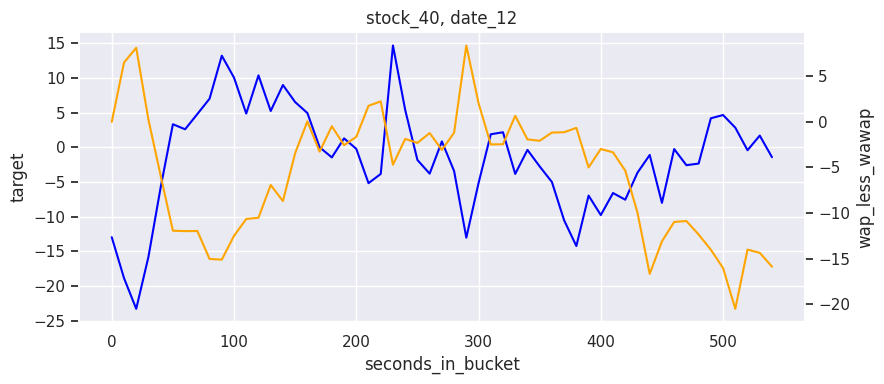

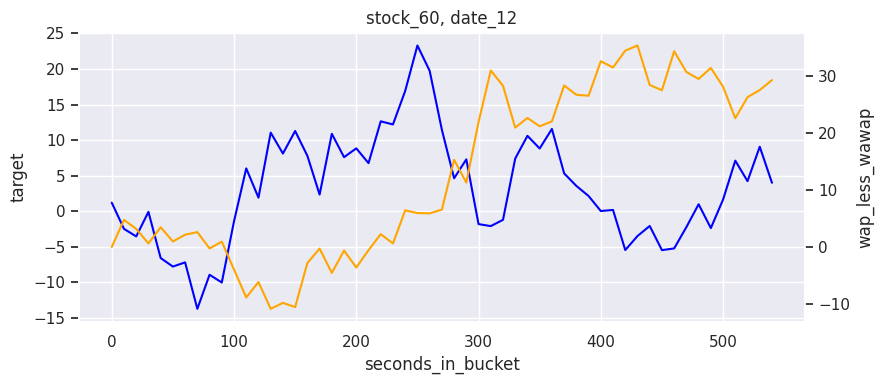

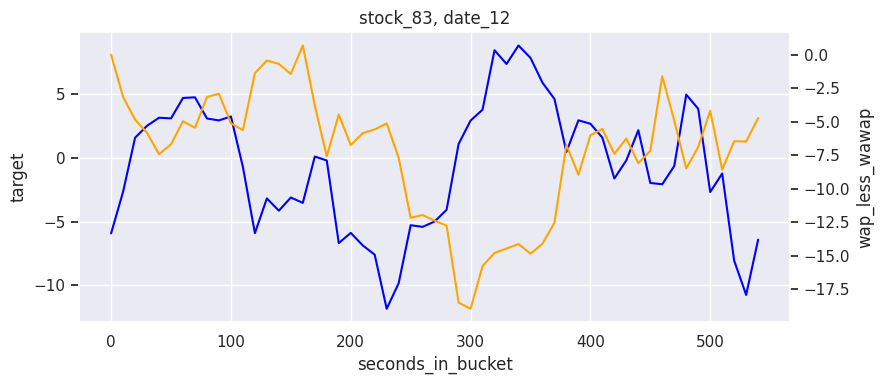

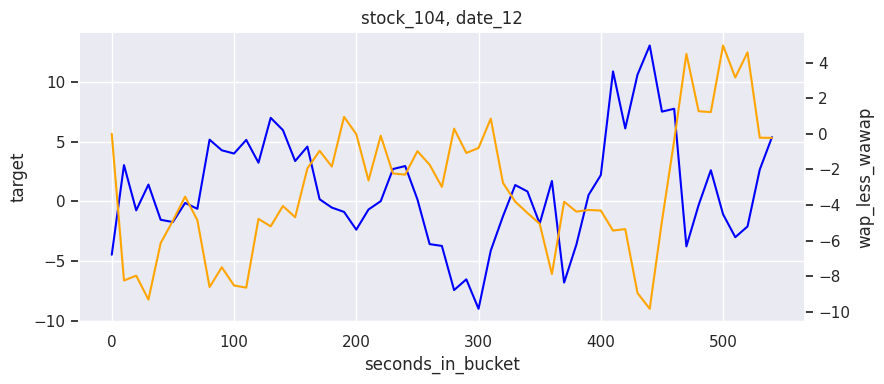

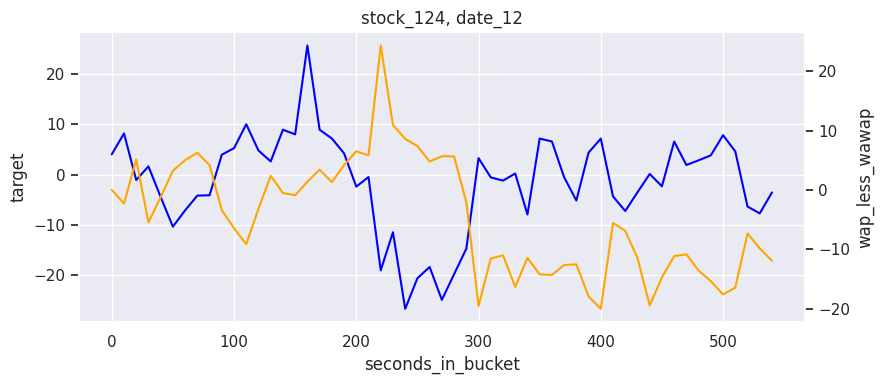

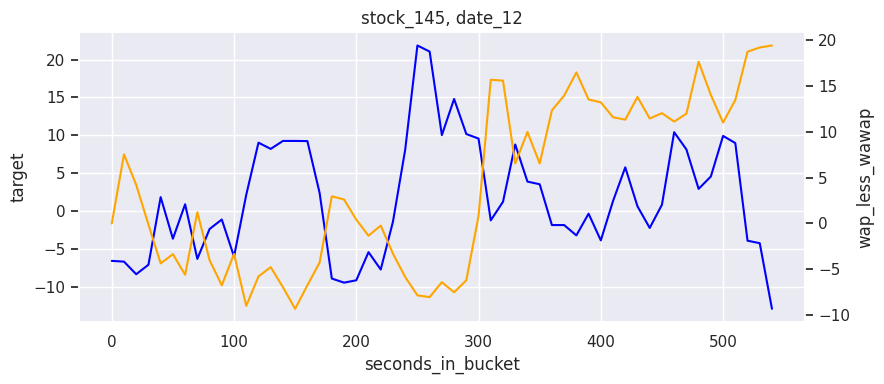

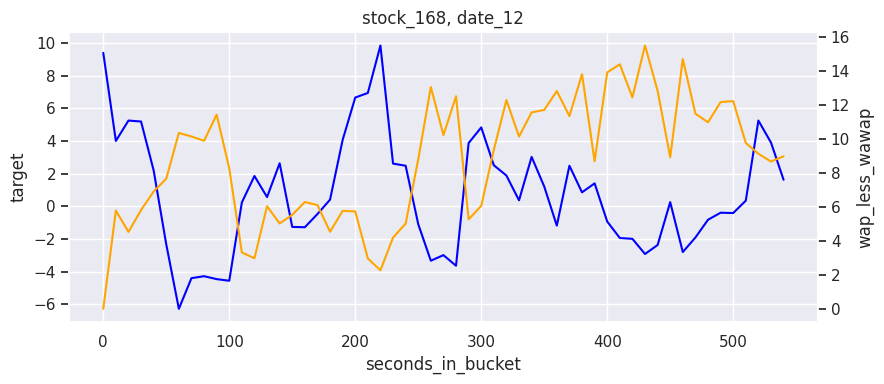

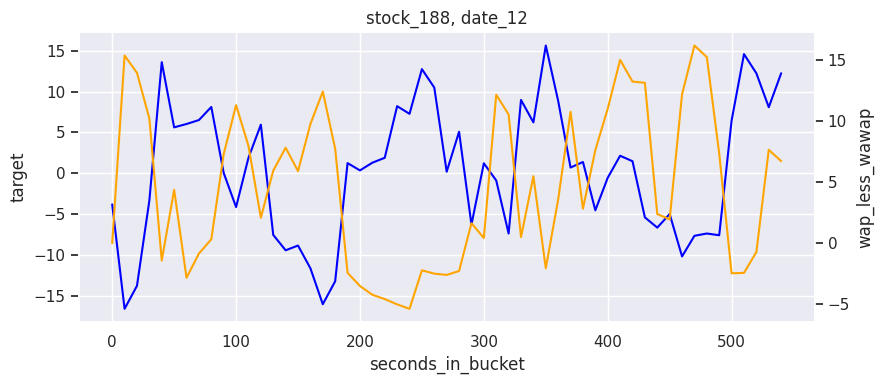

In [17]:
dateid = 12 #just a random date
_ = df.query(f"date_id == {dateid}") 
for i, stock in enumerate(df.stock_id.unique()):
    if i % 20 == 0:
        sns.lineplot(data = _.query(f"stock_id == {stock}"), x = 'seconds_in_bucket', y = 'target', color = 'blue')
        ax2 = plt.twinx()
        sns.lineplot(data = _.query(f"stock_id == {stock}"), x = 'seconds_in_bucket', y = 'wap_less_wawap', color = 'orange', ax = ax2)
        ax2.grid(False)
        plt.title(f'stock_{stock}, date_{dateid}')
        plt.tight_layout()
        plt.show()
